# Story 3.2 Extension: Box-Score Statistical Distribution Analysis

**Purpose:** Characterize the statistical distribution of each box-score metric *independently*
(not in relation to tournament outcomes), to inform normalization and feature engineering
decisions in Epic 4.

**Data coverage:**

| Dataset | Rows | Seasons |
|---------|------|---------|
| Men's Regular Season Detailed | ~118,882 | 2003–2025 |
| Men's Tournament Detailed | ~1,382 | 2003–2024 |
| Women's Regular Season Detailed | ~81,708 | 2010–2025 |
| Women's Tournament Detailed | ~894 | 2010–2024 |

Each game produces 2 team-game observations (winner row + loser row), so the combined
analysis has ~400K–800K observations per stat depending on the filter.

**Methodology:**
- **Histogram + PDF fit:** Density histogram with overlaid fitted Normal and Log-Normal PDFs
  (Log-Normal skipped for bounded [0,1] rates).
- **Empirical CDF:** Step-wise ECDF with theoretical Normal CDF overlay for Combined data.
- **Q-Q plot:** Ordered sample quantiles vs. theoretical Normal quantiles (sub-sampled to
  ≤5,000 pts per gender for display performance).
- **Normality test:** D'Agostino K² (`scipy.stats.normaltest`) — valid for N>2,000;
  Shapiro-Wilk is NOT used (invalid for N>5,000).
- **Rendering:** matplotlib static PNG (not Plotly) to keep notebook file size manageable.

**Stats analyzed (18 total):**
- **Group 1 — High-volume counting:** FGM, FGA, FTM, FTA, DR, Score
- **Group 2 — Low-volume / right-skewed:** FGM3, FGA3, OR, Ast, TO, Stl, Blk, PF
- **Group 3 — Bounded [0,1] efficiency rates:** FGPct, 3PPct, FTPct, TO_rate

**Splits:** Men | Women | Combined (M+W) × Regular Season | Tournament | All Games

In [1]:
# ── Imports + data loading + dist_df construction ────────────────────────────
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as sp_stats

warnings.filterwarnings("ignore", category=RuntimeWarning)
plt.style.use("dark_background")
matplotlib.rcParams.update({
    "figure.dpi": 110,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

KAGGLE_DIR = Path("../../data/kaggle")
STAT_COLS  = ["FGM","FGA","FGM3","FGA3","FTM","FTA","OR","DR","Ast","TO","Stl","Blk","PF","Score"]
W_COLS = [f"W{c}" for c in STAT_COLS]
L_COLS = [f"L{c}" for c in STAT_COLS]
RENAME_W = dict(zip(["WTeamID"] + W_COLS, ["TeamID"] + STAT_COLS))
RENAME_L = dict(zip(["LTeamID"] + L_COLS, ["TeamID"] + STAT_COLS))

# ── Load raw CSVs ─────────────────────────────────────────────────────────────
m_reg  = pd.read_csv(KAGGLE_DIR / "MRegularSeasonDetailedResults.csv")
m_tour = pd.read_csv(KAGGLE_DIR / "MNCAATourneyDetailedResults.csv")
w_reg  = pd.read_csv(KAGGLE_DIR / "WRegularSeasonDetailedResults.csv")
w_tour = pd.read_csv(KAGGLE_DIR / "WNCAATourneyDetailedResults.csv")

print(f"Men's   Regular Season: {len(m_reg):>7,} rows  seasons {m_reg['Season'].min()}–{m_reg['Season'].max()}")
print(f"Men's   Tournament:     {len(m_tour):>7,} rows  seasons {m_tour['Season'].min()}–{m_tour['Season'].max()}")
print(f"Women's Regular Season: {len(w_reg):>7,} rows  seasons {w_reg['Season'].min()}–{w_reg['Season'].max()}")
print(f"Women's Tournament:     {len(w_tour):>7,} rows  seasons {w_tour['Season'].min()}–{w_tour['Season'].max()}")

# ── Stacking helper ───────────────────────────────────────────────────────────
def stack_detail_df(df: pd.DataFrame, gender: str, dataset_type: str) -> pd.DataFrame:
    """Stack winner + loser rows into one long-form DataFrame of team-game observations."""
    w_rows = (
        df[["Season", "WTeamID"] + W_COLS]
        .rename(columns=RENAME_W)
        .assign(game_role="Winner", gender=gender, dataset_type=dataset_type)
    )
    l_rows = (
        df[["Season", "LTeamID"] + L_COLS]
        .rename(columns=RENAME_L)
        .assign(game_role="Loser", gender=gender, dataset_type=dataset_type)
    )
    out = pd.concat([w_rows, l_rows], ignore_index=True)
    # Derived efficiency stats
    out["FGPct"]   = out["FGM"]  / out["FGA"].clip(lower=1)
    out["3PPct"]   = out["FGM3"] / out["FGA3"].clip(lower=1)
    out["FTPct"]   = out["FTM"]  / out["FTA"].clip(lower=1)
    out["TO_rate"] = out["TO"] / (out["FGA"] + 0.44 * out["FTA"] + out["TO"]).clip(lower=1)
    return out

# ── Build dist_df ─────────────────────────────────────────────────────────────
# Step 1: 4 base source splits
base_df = pd.concat([
    stack_detail_df(m_reg,  "Men",   "Regular Season"),
    stack_detail_df(m_tour, "Men",   "Tournament"),
    stack_detail_df(w_reg,  "Women", "Regular Season"),
    stack_detail_df(w_tour, "Women", "Tournament"),
], ignore_index=True)

# Step 2: Combined gender = copy of base with gender overwritten
combined_rows = base_df.copy()
combined_rows["gender"] = "Combined"
df_with_combined = pd.concat([base_df, combined_rows], ignore_index=True)

# Step 3: All Games = copy of everything with dataset_type overwritten
all_games_rows = df_with_combined.copy()
all_games_rows["dataset_type"] = "All Games"
dist_df = pd.concat([df_with_combined, all_games_rows], ignore_index=True)

GENDERS       = ["Men", "Women", "Combined"]
DATASET_TYPES = ["Regular Season", "Tournament", "All Games"]
COLORS        = {"Men": "#636EFA", "Women": "#EF553B", "Combined": "#00CC96"}
DERIVED_COLS  = ["FGPct", "3PPct", "FTPct", "TO_rate"]
ALL_STAT_COLS = STAT_COLS + DERIVED_COLS
BOUNDED       = set(DERIVED_COLS)

print(f"\ndist_df shape: {dist_df.shape}")
for g in GENDERS:
    for dt in DATASET_TYPES:
        n = (dist_df["gender"] == g) & (dist_df["dataset_type"] == dt)
        print(f"  {g:9s} | {dt:16s}: {n.sum():>9,} rows")

Men's   Regular Season: 118,882 rows  seasons 2003–2025
Men's   Tournament:       1,382 rows  seasons 2003–2024
Women's Regular Season:  81,708 rows  seasons 2010–2025
Women's Tournament:         894 rows  seasons 2010–2024



dist_df shape: (1622928, 23)
  Men       | Regular Season  :   237,764 rows


  Men       | Tournament      :     2,764 rows
  Men       | All Games       :   240,528 rows


  Women     | Regular Season  :   163,416 rows
  Women     | Tournament      :     1,788 rows


  Women     | All Games       :   165,204 rows
  Combined  | Regular Season  :   401,180 rows


  Combined  | Tournament      :     4,552 rows
  Combined  | All Games       :   405,732 rows


In [2]:
# ── Distribution analysis helpers ─────────────────────────────────────────────

def distribution_stats(series: pd.Series, label: str = "") -> dict:
    """Compute distributional statistics for a numeric series."""
    data = series.dropna().values
    n = len(data)
    if n < 8:
        return {"label": label, "n": n, "shape_label": "insufficient data",
                "recommended_transform": "?", "recommended_scaler": "?"}
    mean   = float(np.mean(data))
    std    = float(np.std(data, ddof=1))
    skew   = float(sp_stats.skew(data))
    exkurt = float(sp_stats.kurtosis(data))         # excess kurtosis (Fisher, normal=0)
    _, pval = sp_stats.normaltest(data)             # D'Agostino K²

    # Determine stat name from label "stat | gender | dataset_type"
    stat_name = label.split(" | ")[0].strip() if " | " in label else label

    if stat_name in BOUNDED:
        shape, transform, scaler = "bounded [0,1]", "logit", "StandardScaler"
    elif abs(skew) < 0.5 and abs(exkurt) < 1.0:
        shape, transform, scaler = "approx. normal", "none", "StandardScaler"
    elif 0.5 <= skew < 1.0:
        shape, transform, scaler = "mildly right-skewed", "sqrt", "RobustScaler"
    elif skew >= 1.0:
        shape, transform, scaler = "right-skewed", "log1p", "StandardScaler"
    elif skew <= -0.5:
        shape, transform, scaler = "left-skewed", "reflect+log1p", "StandardScaler"
    else:
        shape, transform, scaler = "approx. normal", "none", "StandardScaler"

    return {
        "label": label, "n": n, "mean": mean, "std": std,
        "skewness": skew, "excess_kurtosis": exkurt,
        "normaltest_pvalue": float(pval),
        "shape_label": shape,
        "recommended_transform": transform,
        "recommended_scaler": scaler,
    }


def make_stat_figure(stat_col: str, dist_df: pd.DataFrame) -> plt.Figure:
    """
    3-row × 3-col subplot figure for one stat.
      Cols: Regular Season | Tournament | All Games
      Row 1: Density histogram (Men/Women/Combined, alpha=0.45)
             + Normal PDF fit (orange dashed) for Combined
             + Log-Normal PDF (purple dotted) for Combined, skipped if bounded
      Row 2: Empirical CDF (Men/Women/Combined) + Normal CDF (orange dashed) for Combined
      Row 3: Q-Q plot vs Normal (Men/Women/Combined, subsampled ≤5000 pts each)
    """
    is_bounded = stat_col in BOUNDED
    fig, axes = plt.subplots(3, 3, figsize=(16, 11))
    fig.suptitle(f"Distribution Analysis: {stat_col}", fontsize=15, fontweight="bold", y=0.99)

    col_labels = ["Regular Season", "Tournament", "All Games"]
    row_labels  = ["Density", "Empirical CDF", "Q-Q vs Normal"]

    for col_idx, dt in enumerate(DATASET_TYPES):
        subset = dist_df[dist_df["dataset_type"] == dt]

        # Gather data per gender
        series_map = {}
        for g in GENDERS:
            if g == "Combined":
                s = subset[stat_col].dropna().values
            else:
                s = subset[subset["gender"] == g][stat_col].dropna().values
            series_map[g] = s

        comb = series_map["Combined"]

        # ── Row 1: Density histogram ──────────────────────────────────────────
        ax1 = axes[0, col_idx]
        xmin = float(np.percentile(comb, 0.5)) if len(comb) > 0 else 0
        xmax = float(np.percentile(comb, 99.5)) if len(comb) > 0 else 1

        for g in GENDERS:
            data = series_map[g]
            if len(data) == 0:
                continue
            ax1.hist(data, bins=60, density=True, alpha=0.45,
                     color=COLORS[g], label=g, range=(xmin, xmax))

        if len(comb) > 8:
            x_range = np.linspace(xmin, xmax, 300)
            mu, sigma = sp_stats.norm.fit(comb)
            ax1.plot(x_range, sp_stats.norm.pdf(x_range, mu, sigma),
                     "--", color="#FFA15A", lw=2, label="Normal fit")
            if not is_bounded:
                pos = comb[comb > 0]
                if len(pos) > 8:
                    shape_ln, loc_ln, scale_ln = sp_stats.lognorm.fit(pos, floc=0)
                    x_pos = x_range.clip(min=1e-9)
                    ax1.plot(x_pos,
                             sp_stats.lognorm.pdf(x_pos, shape_ln, loc_ln, scale_ln),
                             ":", color="#AB63FA", lw=2, label="Log-Normal fit")

        ax1.set_title(f"{col_labels[col_idx]}", fontsize=10)
        ax1.set_ylabel(row_labels[0] if col_idx == 0 else "", fontsize=9)
        if col_idx == 0:
            ax1.legend(fontsize=7, loc="upper right")

        # ── Row 2: Empirical CDF ──────────────────────────────────────────────
        ax2 = axes[1, col_idx]
        for g in GENDERS:
            data = np.sort(series_map[g])
            if len(data) == 0:
                continue
            ecdf_y = np.arange(1, len(data) + 1) / len(data)
            ax2.plot(data, ecdf_y, color=COLORS[g], lw=1.5, label=g)

        if len(comb) > 8:
            comb_s = np.sort(comb)
            mu, sigma = sp_stats.norm.fit(comb_s)
            x_cdf = np.linspace(float(comb_s[0]), float(comb_s[-1]), 300)
            ax2.plot(x_cdf, sp_stats.norm.cdf(x_cdf, mu, sigma),
                     "--", color="#FFA15A", lw=1.5, label="Normal CDF")

        ax2.set_ylabel(row_labels[1] if col_idx == 0 else "", fontsize=9)
        ax2.set_ylim(0, 1)

        # ── Row 3: Q-Q plot ───────────────────────────────────────────────────
        ax3 = axes[2, col_idx]
        for g in GENDERS:
            data = series_map[g]
            if len(data) < 8:
                continue
            rng = np.random.default_rng(42)
            sample = data if len(data) <= 5_000 else rng.choice(data, 5_000, replace=False)
            (osm, osr), (slope, intercept, _r) = sp_stats.probplot(sample, dist="norm")
            ax3.scatter(osm, osr, color=COLORS[g], s=2, alpha=0.4, label=g)
            ax3.plot([float(osm[0]), float(osm[-1])],
                     [slope * float(osm[0]) + intercept, slope * float(osm[-1]) + intercept],
                     "--", color=COLORS[g], lw=1, alpha=0.7)

        ax3.set_ylabel(row_labels[2] if col_idx == 0 else "", fontsize=9)
        ax3.set_xlabel("Theoretical Normal Quantiles", fontsize=8)

    fig.tight_layout(rect=[0, 0, 1, 0.98])
    return fig


print("Helpers defined: distribution_stats(), make_stat_figure()")
print(f"Stats to analyze: {len(ALL_STAT_COLS)} total ({len(STAT_COLS)} raw + {len(DERIVED_COLS)} derived)")

Helpers defined: distribution_stats(), make_stat_figure()
Stats to analyze: 18 total (14 raw + 4 derived)



────────────────────────────────────────────────────────────  FGM


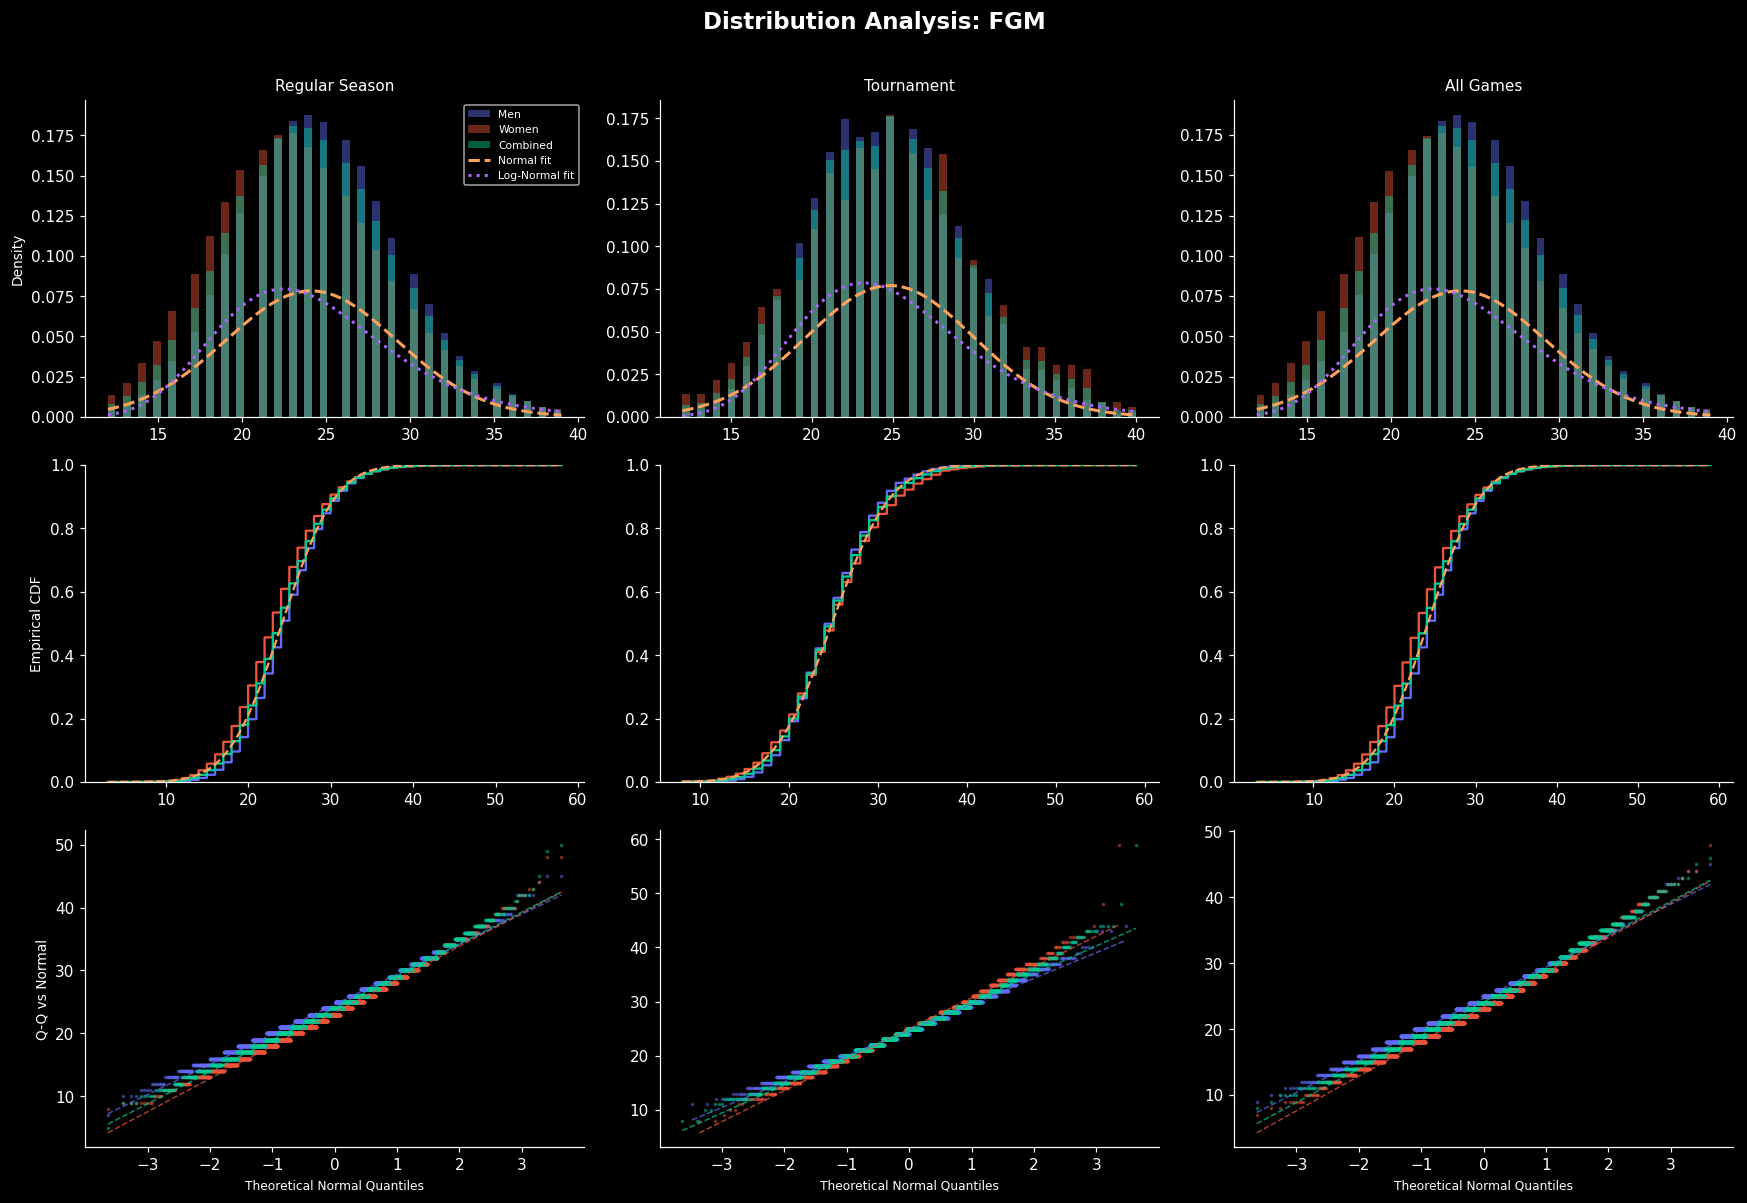

  Men       | Regular Season   n= 237,764  mean= 24.61  std= 4.86  skew=+0.29  exkurt=+0.31  p=0.0e+00  → approx. normal
  Women     | Regular Season   n= 163,416  mean= 23.37  std= 5.33  skew=+0.38  exkurt=+0.42  p=0.0e+00  → approx. normal
  Combined  | Regular Season   n= 802,360  mean= 24.11  std= 5.10  skew=+0.29  exkurt=+0.34  p=0.0e+00  → approx. normal


  Men       | Tournament       n=   2,764  mean= 24.73  std= 4.79  skew=+0.32  exkurt=+0.13  p=4.3e-11  → approx. normal
  Women     | Tournament       n=   1,788  mean= 24.96  std= 5.74  skew=+0.36  exkurt=+0.75  p=8.2e-14  → approx. normal
  Combined  | Tournament       n=   9,104  mean= 24.82  std= 5.18  skew=+0.36  exkurt=+0.61  p=8.3e-59  → approx. normal


  Men       | All Games        n= 240,528  mean= 24.61  std= 4.86  skew=+0.29  exkurt=+0.31  p=0.0e+00  → approx. normal
  Women     | All Games        n= 165,204  mean= 23.39  std= 5.34  skew=+0.38  exkurt=+0.42  p=0.0e+00  → approx. normal
  Combined  | All Games        n= 811,464  mean= 24.11  std= 5.10  skew=+0.29  exkurt=+0.34  p=0.0e+00  → approx. normal

────────────────────────────────────────────────────────────  FGA


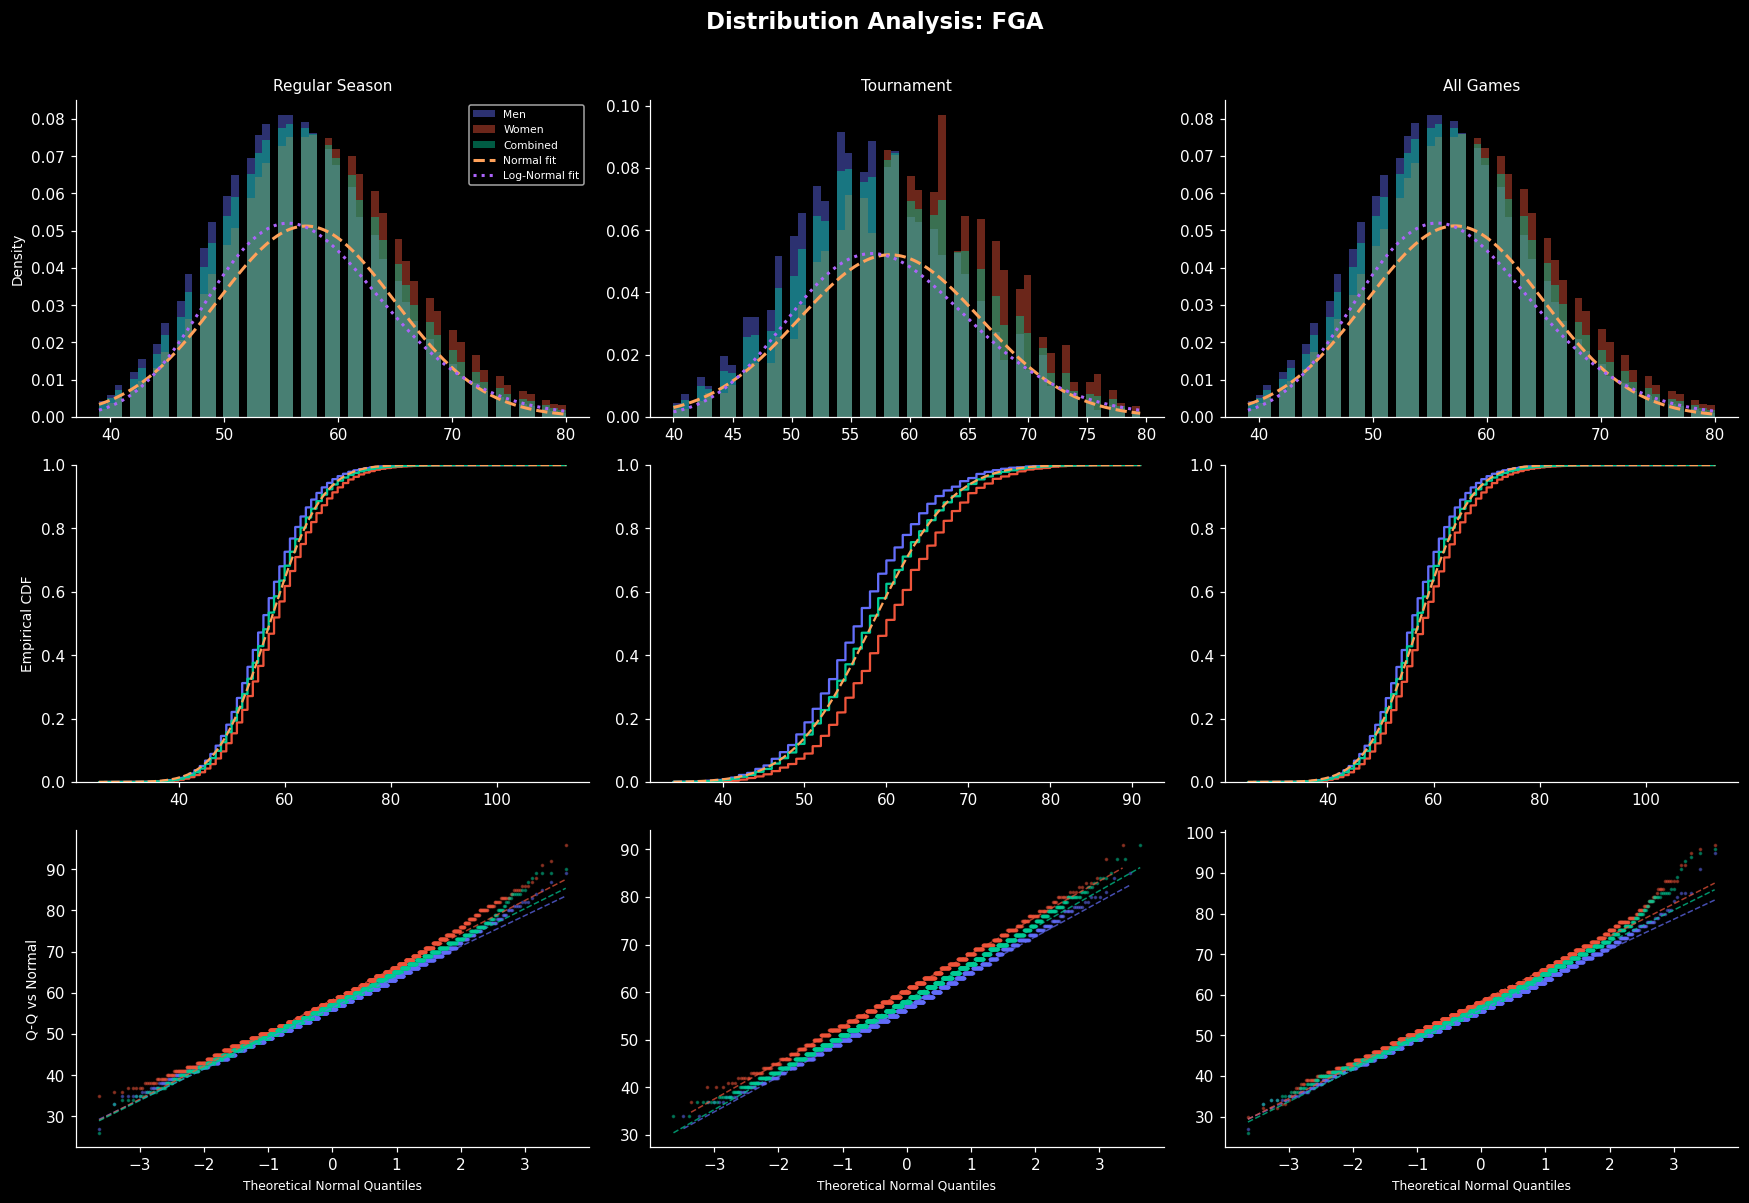

  Men       | Regular Season   n= 237,764  mean= 56.29  std= 7.51  skew=+0.27  exkurt=+0.37  p=0.0e+00  → approx. normal
  Women     | Regular Season   n= 163,416  mean= 58.49  std= 7.99  skew=+0.34  exkurt=+0.51  p=0.0e+00  → approx. normal
  Combined  | Regular Season   n= 802,360  mean= 57.19  std= 7.79  skew=+0.32  exkurt=+0.47  p=0.0e+00  → approx. normal


  Men       | Tournament       n=   2,764  mean= 56.93  std= 7.36  skew=+0.20  exkurt=+0.07  p=1.0e-04  → approx. normal
  Women     | Tournament       n=   1,788  mean= 60.45  std= 7.63  skew=+0.12  exkurt=+0.05  p=1.1e-01  → approx. normal
  Combined  | Tournament       n=   9,104  mean= 58.31  std= 7.66  skew=+0.18  exkurt=+0.03  p=2.3e-11  → approx. normal


  Men       | All Games        n= 240,528  mean= 56.30  std= 7.51  skew=+0.26  exkurt=+0.36  p=0.0e+00  → approx. normal
  Women     | All Games        n= 165,204  mean= 58.51  std= 7.99  skew=+0.34  exkurt=+0.51  p=0.0e+00  → approx. normal
  Combined  | All Games        n= 811,464  mean= 57.20  std= 7.79  skew=+0.32  exkurt=+0.46  p=0.0e+00  → approx. normal

────────────────────────────────────────────────────────────  Score


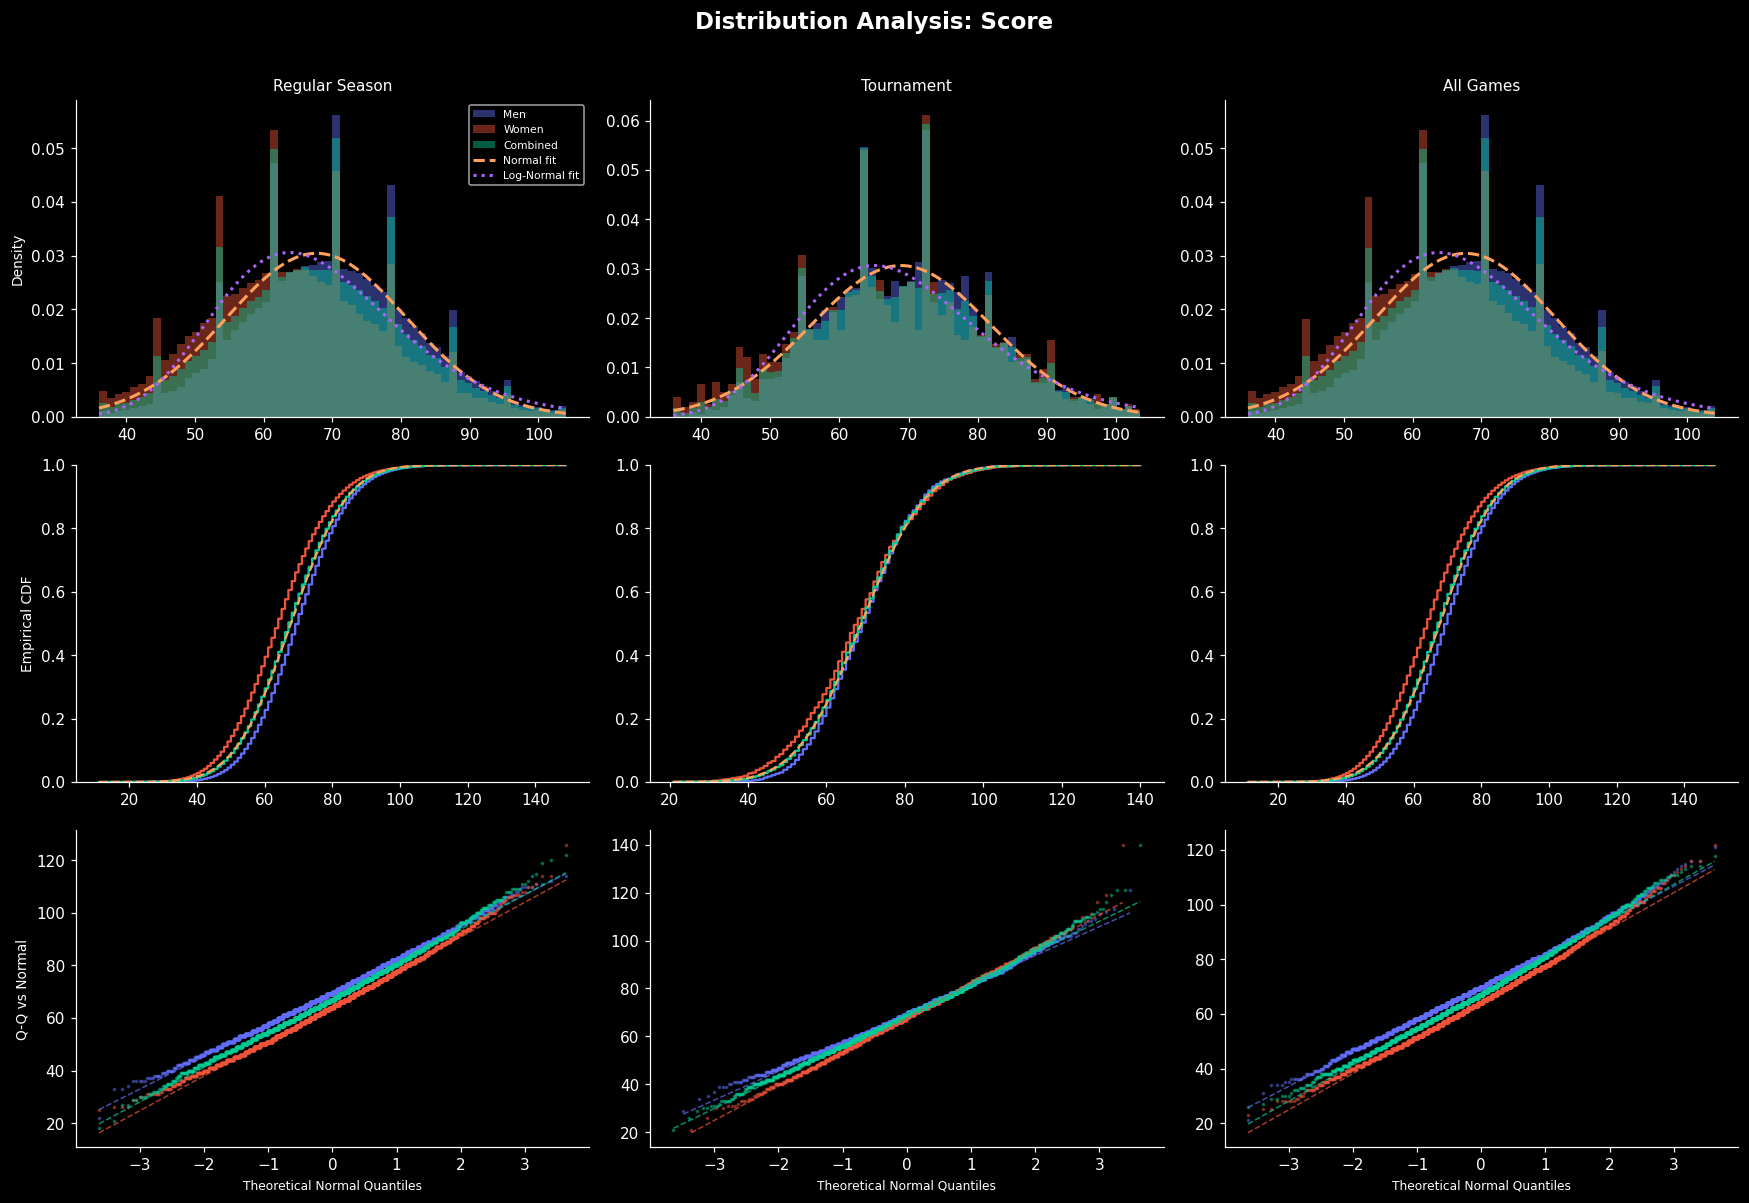

  Men       | Regular Season   n= 237,764  mean= 69.91  std=12.46  skew=+0.20  exkurt=+0.18  p=0.0e+00  → approx. normal
  Women     | Regular Season   n= 163,416  mean= 64.48  std=13.36  skew=+0.27  exkurt=+0.24  p=0.0e+00  → approx. normal
  Combined  | Regular Season   n= 802,360  mean= 67.70  std=13.11  skew=+0.17  exkurt=+0.16  p=0.0e+00  → approx. normal


  Men       | Tournament       n=   2,764  mean= 69.59  std=12.08  skew=+0.23  exkurt=+0.09  p=2.8e-06  → approx. normal
  Women     | Tournament       n=   1,788  mean= 67.84  std=14.29  skew=+0.13  exkurt=+0.26  p=9.1e-03  → approx. normal
  Combined  | Tournament       n=   9,104  mean= 68.90  std=13.02  skew=+0.15  exkurt=+0.28  p=8.5e-13  → approx. normal


  Men       | All Games        n= 240,528  mean= 69.91  std=12.45  skew=+0.20  exkurt=+0.18  p=0.0e+00  → approx. normal
  Women     | All Games        n= 165,204  mean= 64.52  std=13.38  skew=+0.27  exkurt=+0.24  p=0.0e+00  → approx. normal
  Combined  | All Games        n= 811,464  mean= 67.71  std=13.11  skew=+0.17  exkurt=+0.16  p=0.0e+00  → approx. normal


In [3]:
# ── Group 1a: FGM, FGA, Score (high-volume counting — CLT effect expected) ────
# Expected: approximately normal distributions due to central-limit effect
# (each game sums many individual shot/possession events).

_all_stats_records = []  # accumulate across all group cells for summary table

for stat in ["FGM", "FGA", "Score"]:
    print(f"\n{'─'*60}  {stat}")
    fig = make_stat_figure(stat, dist_df)
    plt.show()
    plt.close(fig)

    for dt in DATASET_TYPES:
        subset = dist_df[dist_df["dataset_type"] == dt]
        for g in GENDERS:
            s = subset[stat] if g == "Combined" else subset[subset["gender"] == g][stat]
            rec = distribution_stats(s, label=f"{stat} | {g} | {dt}")
            _all_stats_records.append(rec)
            if rec.get("n", 0) >= 8:
                print(
                    f"  {g:9s} | {dt:16s} "
                    f"n={rec['n']:>8,}  mean={rec['mean']:6.2f}  std={rec['std']:5.2f}  "
                    f"skew={rec['skewness']:+.2f}  exkurt={rec['excess_kurtosis']:+.2f}  "
                    f"p={rec['normaltest_pvalue']:.1e}  → {rec['shape_label']}"
                )


────────────────────────────────────────────────────────────  FTM


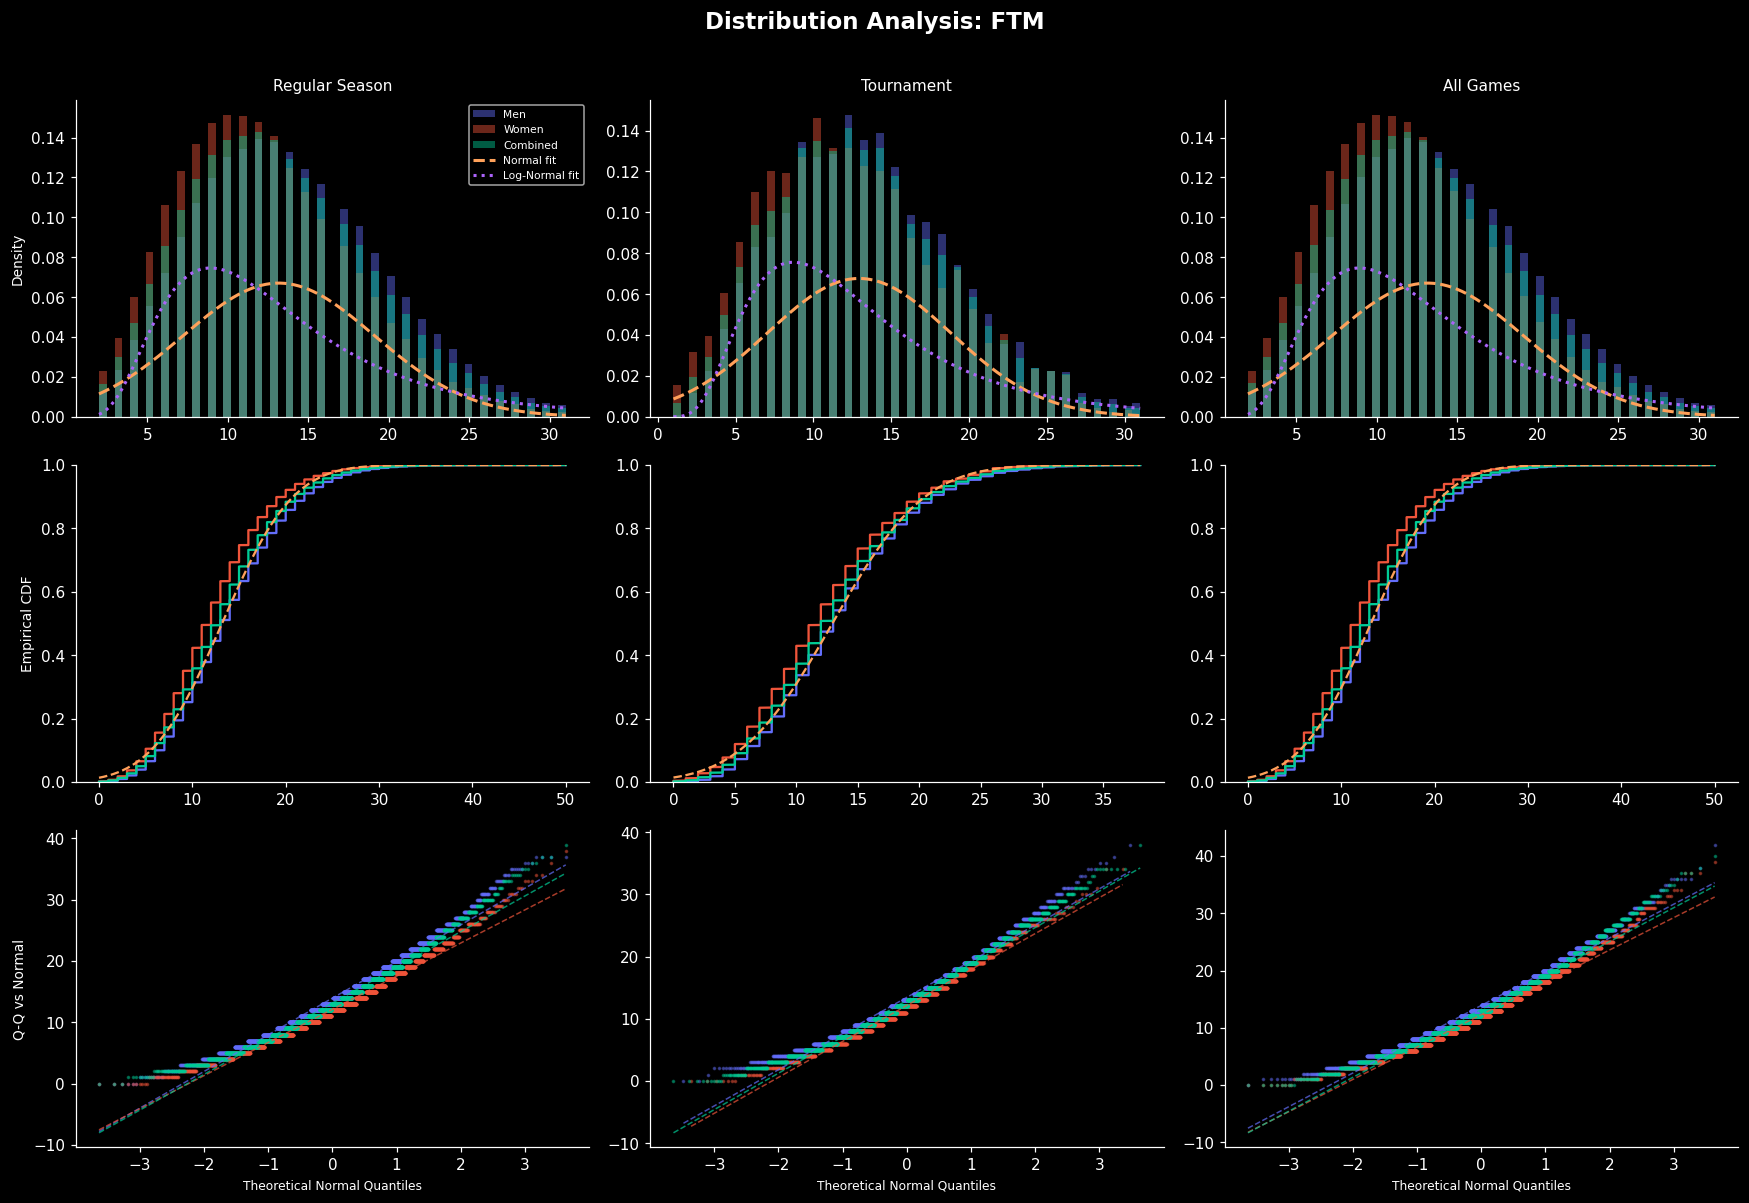

  Men       | Regular Season   n= 237,764  mean= 13.90  std= 6.08  skew=+0.54  exkurt=+0.29  p=0.0e+00  → mildly right-skewed
  Women     | Regular Season   n= 163,416  mean= 12.12  std= 5.59  skew=+0.60  exkurt=+0.46  p=0.0e+00  → mildly right-skewed
  Combined  | Regular Season   n= 802,360  mean= 13.17  std= 5.95  skew=+0.58  exkurt=+0.37  p=0.0e+00  → mildly right-skewed
  Men       | Tournament       n=   2,764  mean= 13.45  std= 5.88  skew=+0.58  exkurt=+0.27  p=2.8e-31  → mildly right-skewed
  Women     | Tournament       n=   1,788  mean= 12.14  std= 5.83  skew=+0.47  exkurt=-0.08  p=4.4e-14  → approx. normal
  Combined  | Tournament       n=   9,104  mean= 12.93  std= 5.89  skew=+0.53  exkurt=+0.16  p=1.7e-84  → mildly right-skewed


  Men       | All Games        n= 240,528  mean= 13.89  std= 6.08  skew=+0.54  exkurt=+0.29  p=0.0e+00  → mildly right-skewed
  Women     | All Games        n= 165,204  mean= 12.12  std= 5.59  skew=+0.60  exkurt=+0.45  p=0.0e+00  → mildly right-skewed
  Combined  | All Games        n= 811,464  mean= 13.17  std= 5.95  skew=+0.58  exkurt=+0.37  p=0.0e+00  → mildly right-skewed

────────────────────────────────────────────────────────────  FTA


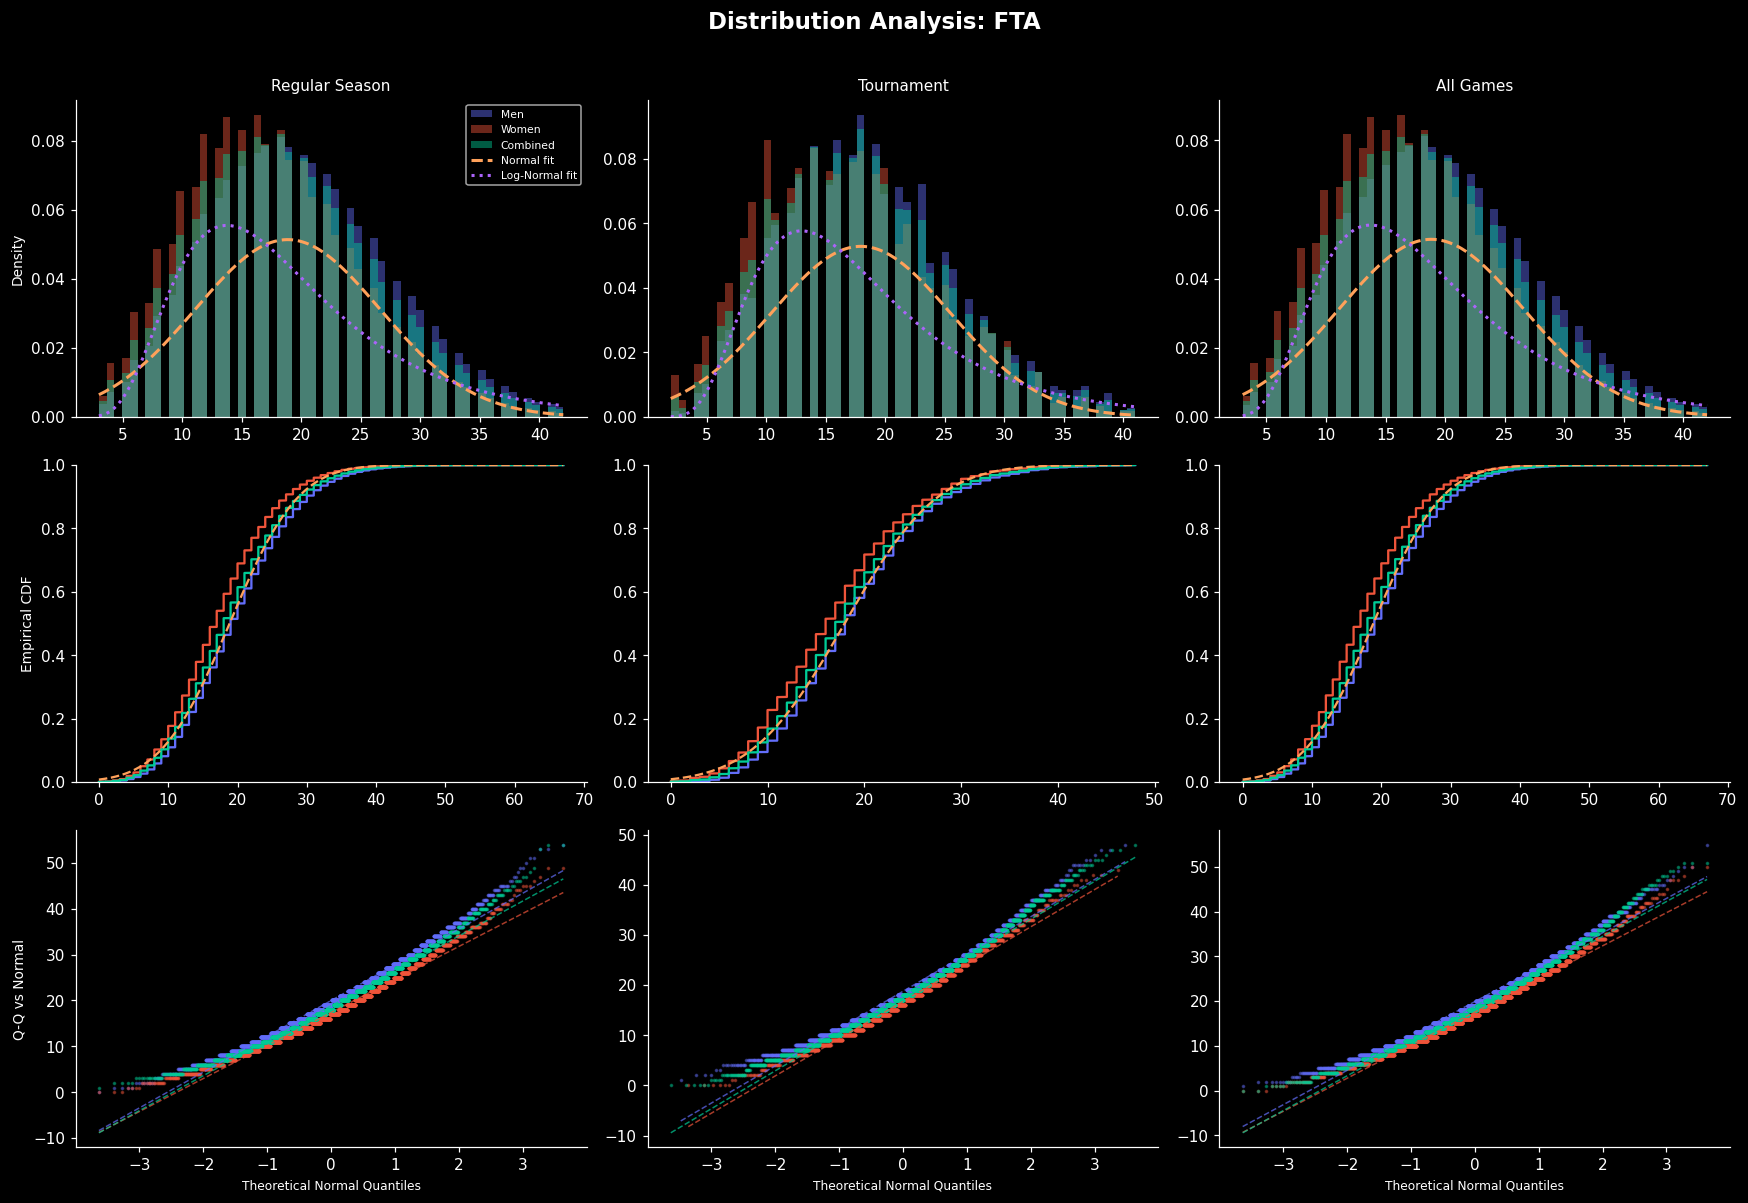

  Men       | Regular Season   n= 237,764  mean= 19.86  std= 7.89  skew=+0.49  exkurt=+0.30  p=0.0e+00  → approx. normal
  Women     | Regular Season   n= 163,416  mean= 17.39  std= 7.34  skew=+0.54  exkurt=+0.36  p=0.0e+00  → mildly right-skewed
  Combined  | Regular Season   n= 802,360  mean= 18.85  std= 7.77  skew=+0.52  exkurt=+0.33  p=0.0e+00  → mildly right-skewed
  Men       | Tournament       n=   2,764  mean= 18.75  std= 7.50  skew=+0.57  exkurt=+0.33  p=2.3e-31  → mildly right-skewed


  Women     | Tournament       n=   1,788  mean= 16.74  std= 7.48  skew=+0.47  exkurt=+0.00  p=1.3e-13  → approx. normal
  Combined  | Tournament       n=   9,104  mean= 17.96  std= 7.56  skew=+0.52  exkurt=+0.22  p=1.9e-82  → mildly right-skewed


  Men       | All Games        n= 240,528  mean= 19.84  std= 7.89  skew=+0.49  exkurt=+0.30  p=0.0e+00  → approx. normal
  Women     | All Games        n= 165,204  mean= 17.38  std= 7.34  skew=+0.54  exkurt=+0.36  p=0.0e+00  → mildly right-skewed
  Combined  | All Games        n= 811,464  mean= 18.84  std= 7.76  skew=+0.52  exkurt=+0.33  p=0.0e+00  → mildly right-skewed

────────────────────────────────────────────────────────────  DR


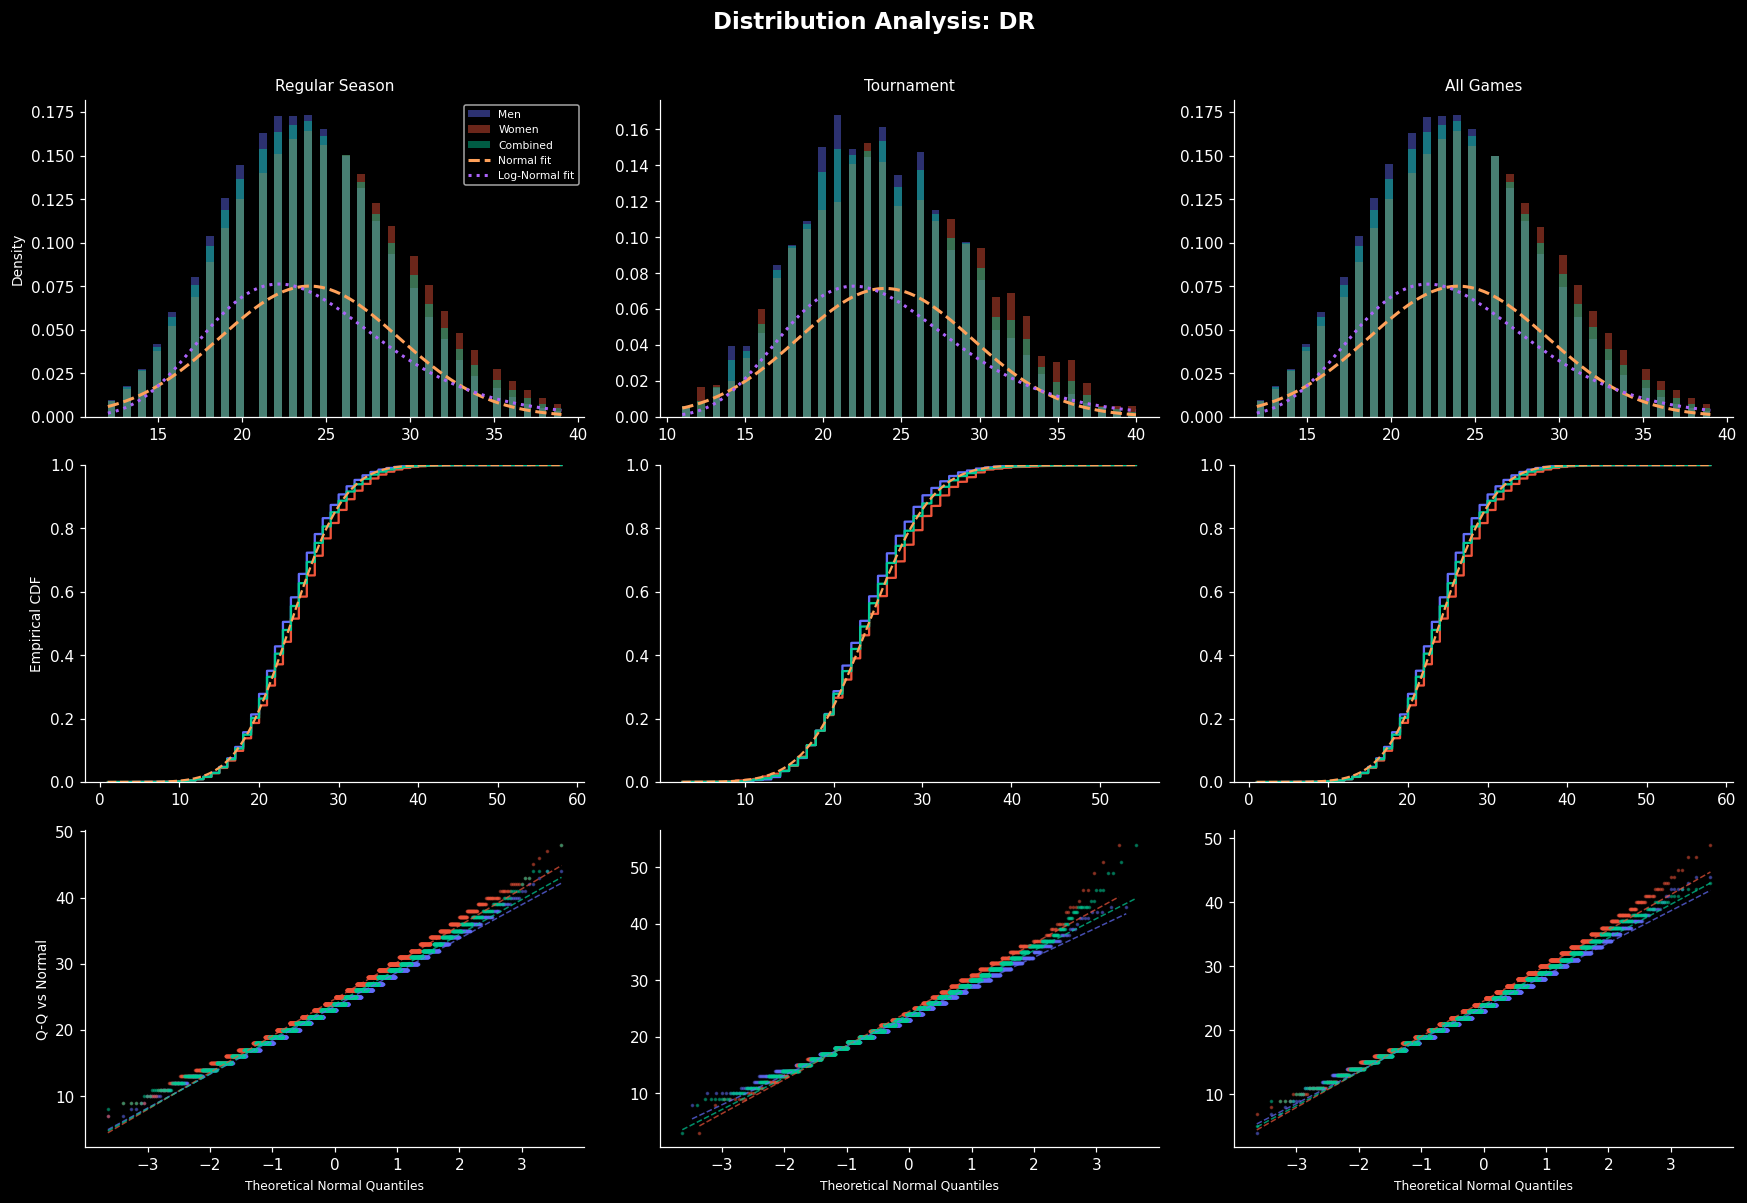

  Men       | Regular Season   n= 237,764  mean= 23.62  std= 5.11  skew=+0.24  exkurt=+0.12  p=0.0e+00  → approx. normal
  Women     | Regular Season   n= 163,416  mean= 24.52  std= 5.56  skew=+0.25  exkurt=+0.07  p=0.0e+00  → approx. normal
  Combined  | Regular Season   n= 802,360  mean= 23.99  std= 5.32  skew=+0.26  exkurt=+0.13  p=0.0e+00  → approx. normal
  Men       | Tournament       n=   2,764  mean= 23.61  std= 5.23  skew=+0.28  exkurt=+0.10  p=1.5e-08  → approx. normal
  Women     | Tournament       n=   1,788  mean= 24.48  std= 6.05  skew=+0.31  exkurt=+0.46  p=3.4e-09  → approx. normal
  Combined  | Tournament       n=   9,104  mean= 23.95  std= 5.58  skew=+0.33  exkurt=+0.38  p=3.3e-43  → approx. normal


  Men       | All Games        n= 240,528  mean= 23.62  std= 5.11  skew=+0.24  exkurt=+0.12  p=0.0e+00  → approx. normal
  Women     | All Games        n= 165,204  mean= 24.52  std= 5.57  skew=+0.25  exkurt=+0.08  p=0.0e+00  → approx. normal
  Combined  | All Games        n= 811,464  mean= 23.99  std= 5.32  skew=+0.26  exkurt=+0.13  p=0.0e+00  → approx. normal


In [4]:
# ── Group 1b: FTM, FTA, DR (high-volume counting continued) ──────────────────
# FTM/FTA: moderate volume, expected roughly normal.
# DR: highest-volume rebound stat — most team-game DR values cluster ~25–35.

for stat in ["FTM", "FTA", "DR"]:
    print(f"\n{'─'*60}  {stat}")
    fig = make_stat_figure(stat, dist_df)
    plt.show()
    plt.close(fig)

    for dt in DATASET_TYPES:
        subset = dist_df[dist_df["dataset_type"] == dt]
        for g in GENDERS:
            s = subset[stat] if g == "Combined" else subset[subset["gender"] == g][stat]
            rec = distribution_stats(s, label=f"{stat} | {g} | {dt}")
            _all_stats_records.append(rec)
            if rec.get("n", 0) >= 8:
                print(
                    f"  {g:9s} | {dt:16s} "
                    f"n={rec['n']:>8,}  mean={rec['mean']:6.2f}  std={rec['std']:5.2f}  "
                    f"skew={rec['skewness']:+.2f}  exkurt={rec['excess_kurtosis']:+.2f}  "
                    f"p={rec['normaltest_pvalue']:.1e}  → {rec['shape_label']}"
                )

Note: FGM3/FGA3 have an era effect — 3-point volume increased significantly post-2010.

────────────────────────────────────────────────────────────  FGM3


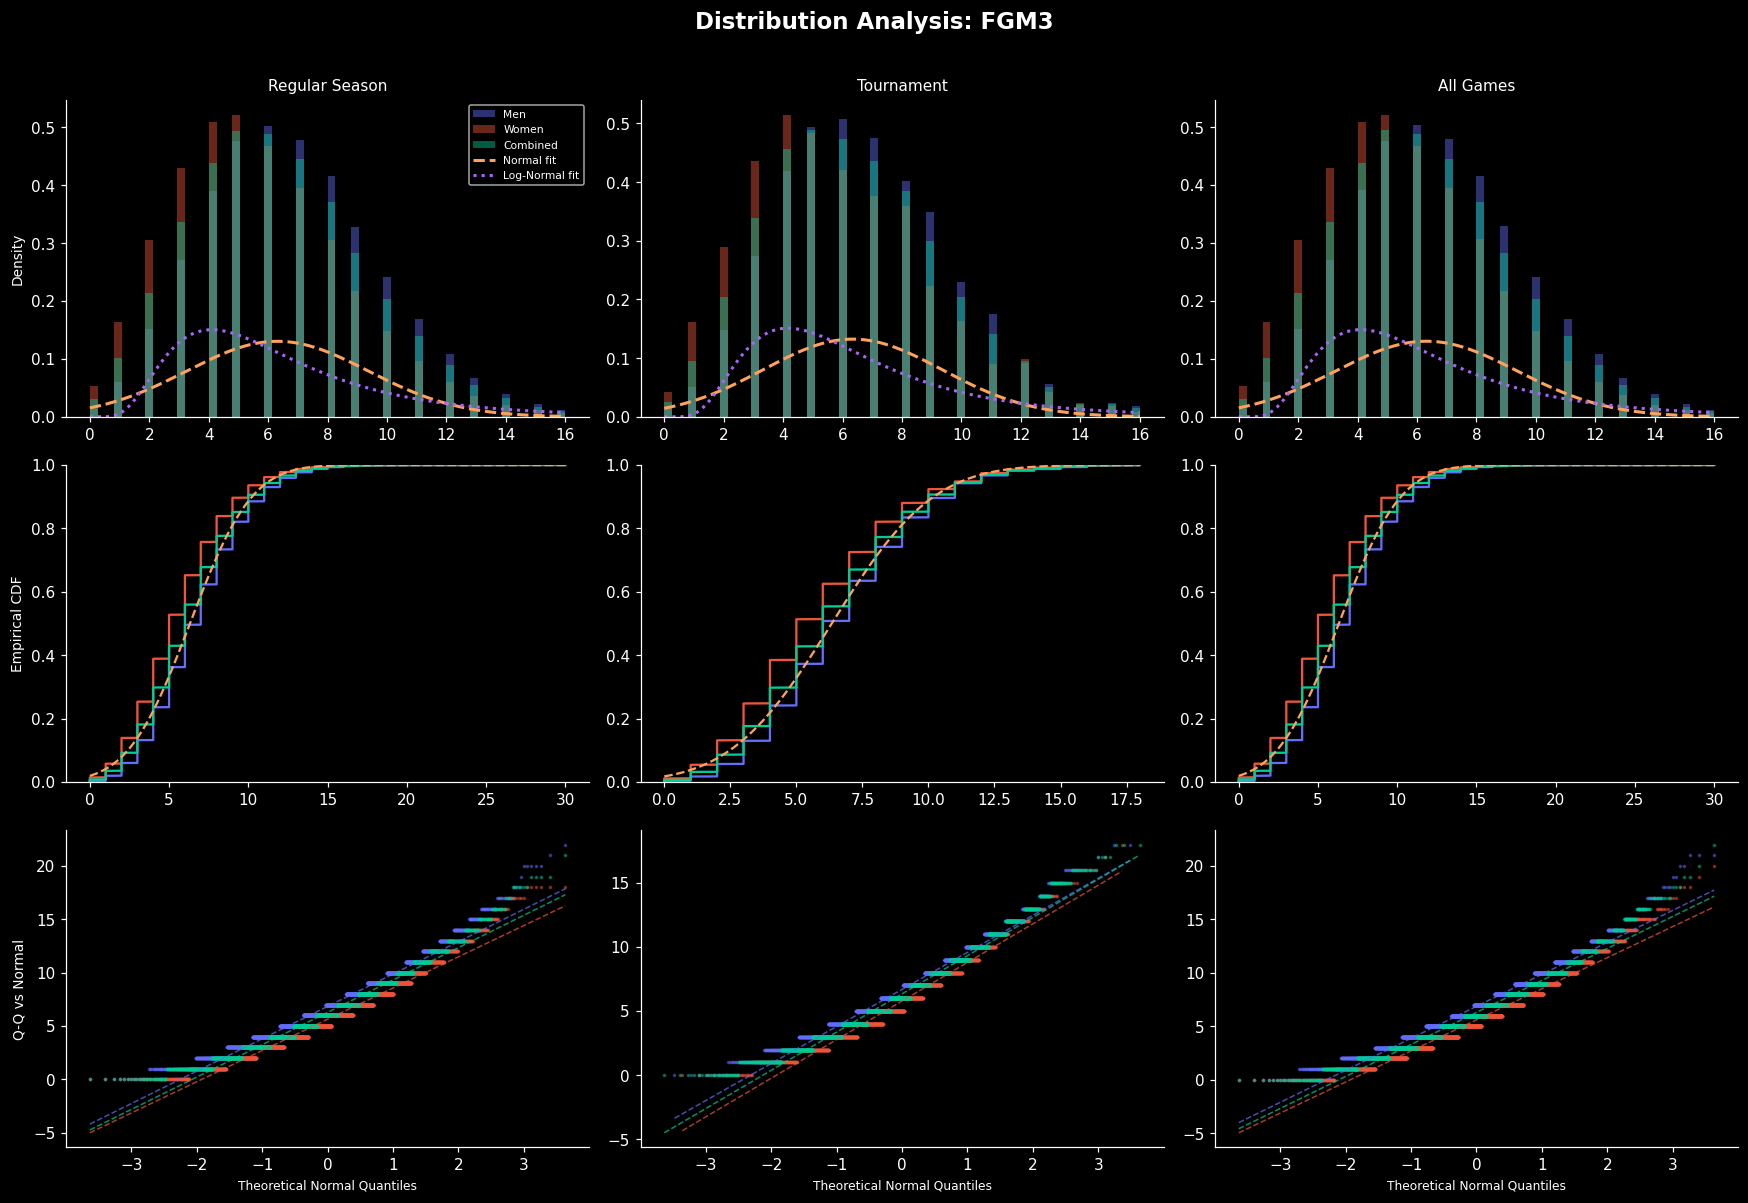

  Men       | Regular Season   n= 237,764  mean=  6.79  std= 3.02  skew=+0.51  exkurt=+0.34  p=0.0e+00  → mildly right-skewed
  Women     | Regular Season   n= 163,416  mean=  5.63  std= 2.97  skew=+0.67  exkurt=+0.64  p=0.0e+00  → mildly right-skewed
  Combined  | Regular Season   n= 802,360  mean=  6.31  std= 3.06  skew=+0.55  exkurt=+0.38  p=0.0e+00  → mildly right-skewed
  Men       | Tournament       n=   2,764  mean=  6.69  std= 2.92  skew=+0.48  exkurt=+0.19  p=1.4e-22  → approx. normal
  Women     | Tournament       n=   1,788  mean=  5.79  std= 3.06  skew=+0.61  exkurt=+0.18  p=7.3e-22  → mildly right-skewed
  Combined  | Tournament       n=   9,104  mean=  6.34  std= 3.01  skew=+0.50  exkurt=+0.13  p=3.9e-75  → approx. normal


  Men       | All Games        n= 240,528  mean=  6.79  std= 3.02  skew=+0.51  exkurt=+0.34  p=0.0e+00  → mildly right-skewed
  Women     | All Games        n= 165,204  mean=  5.63  std= 2.98  skew=+0.67  exkurt=+0.64  p=0.0e+00  → mildly right-skewed
  Combined  | All Games        n= 811,464  mean=  6.31  std= 3.06  skew=+0.55  exkurt=+0.38  p=0.0e+00  → mildly right-skewed

────────────────────────────────────────────────────────────  FGA3


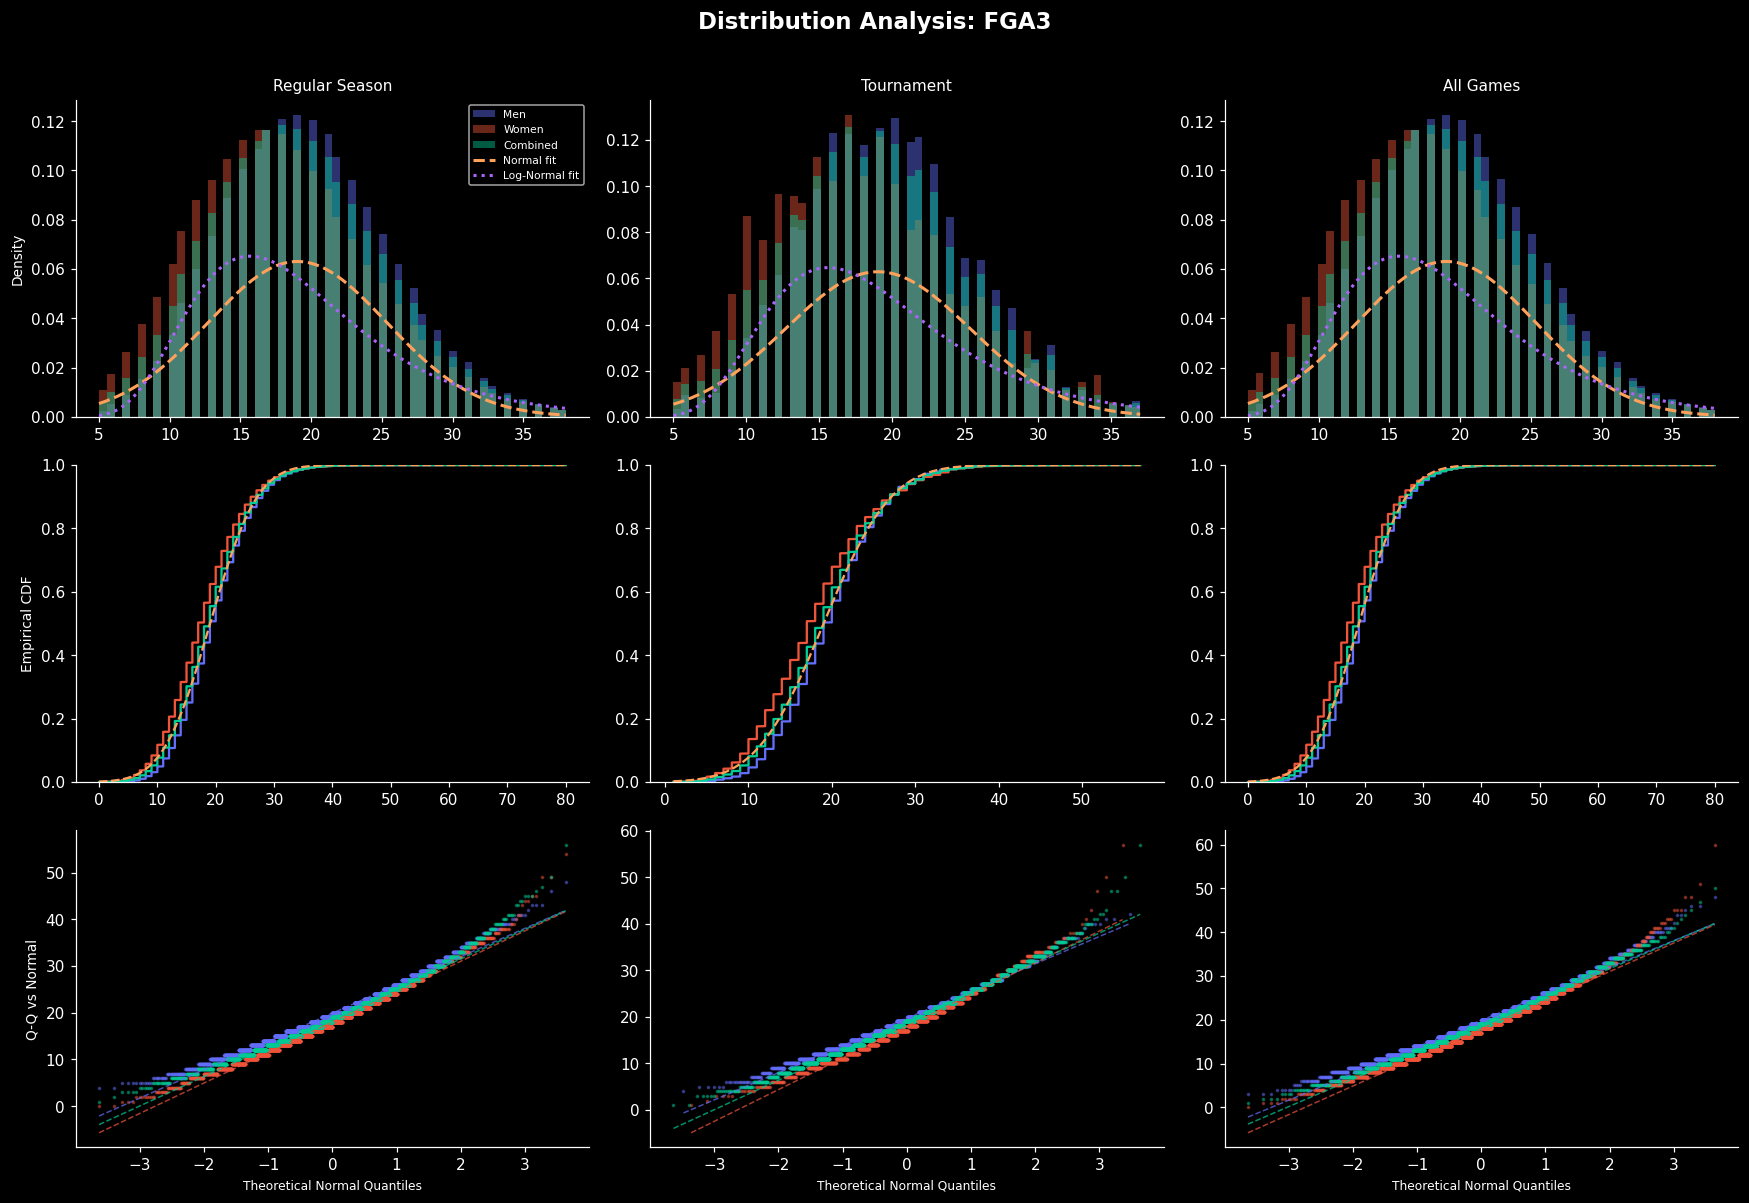

  Men       | Regular Season   n= 237,764  mean= 19.77  std= 6.07  skew=+0.42  exkurt=+0.38  p=0.0e+00  → approx. normal
  Women     | Regular Season   n= 163,416  mean= 17.95  std= 6.54  skew=+0.53  exkurt=+0.65  p=0.0e+00  → mildly right-skewed
  Combined  | Regular Season   n= 802,360  mean= 19.03  std= 6.33  skew=+0.43  exkurt=+0.46  p=0.0e+00  → approx. normal
  Men       | Tournament       n=   2,764  mean= 19.69  std= 5.87  skew=+0.34  exkurt=+0.18  p=2.4e-12  → approx. normal
  Women     | Tournament       n=   1,788  mean= 17.97  std= 6.88  skew=+0.59  exkurt=+0.79  p=5.2e-26  → mildly right-skewed
  Combined  | Tournament       n=   9,104  mean= 19.01  std= 6.34  skew=+0.40  exkurt=+0.46  p=8.7e-61  → approx. normal


  Men       | All Games        n= 240,528  mean= 19.77  std= 6.06  skew=+0.42  exkurt=+0.38  p=0.0e+00  → approx. normal
  Women     | All Games        n= 165,204  mean= 17.95  std= 6.55  skew=+0.53  exkurt=+0.66  p=0.0e+00  → mildly right-skewed
  Combined  | All Games        n= 811,464  mean= 19.03  std= 6.33  skew=+0.43  exkurt=+0.46  p=0.0e+00  → approx. normal

────────────────────────────────────────────────────────────  OR


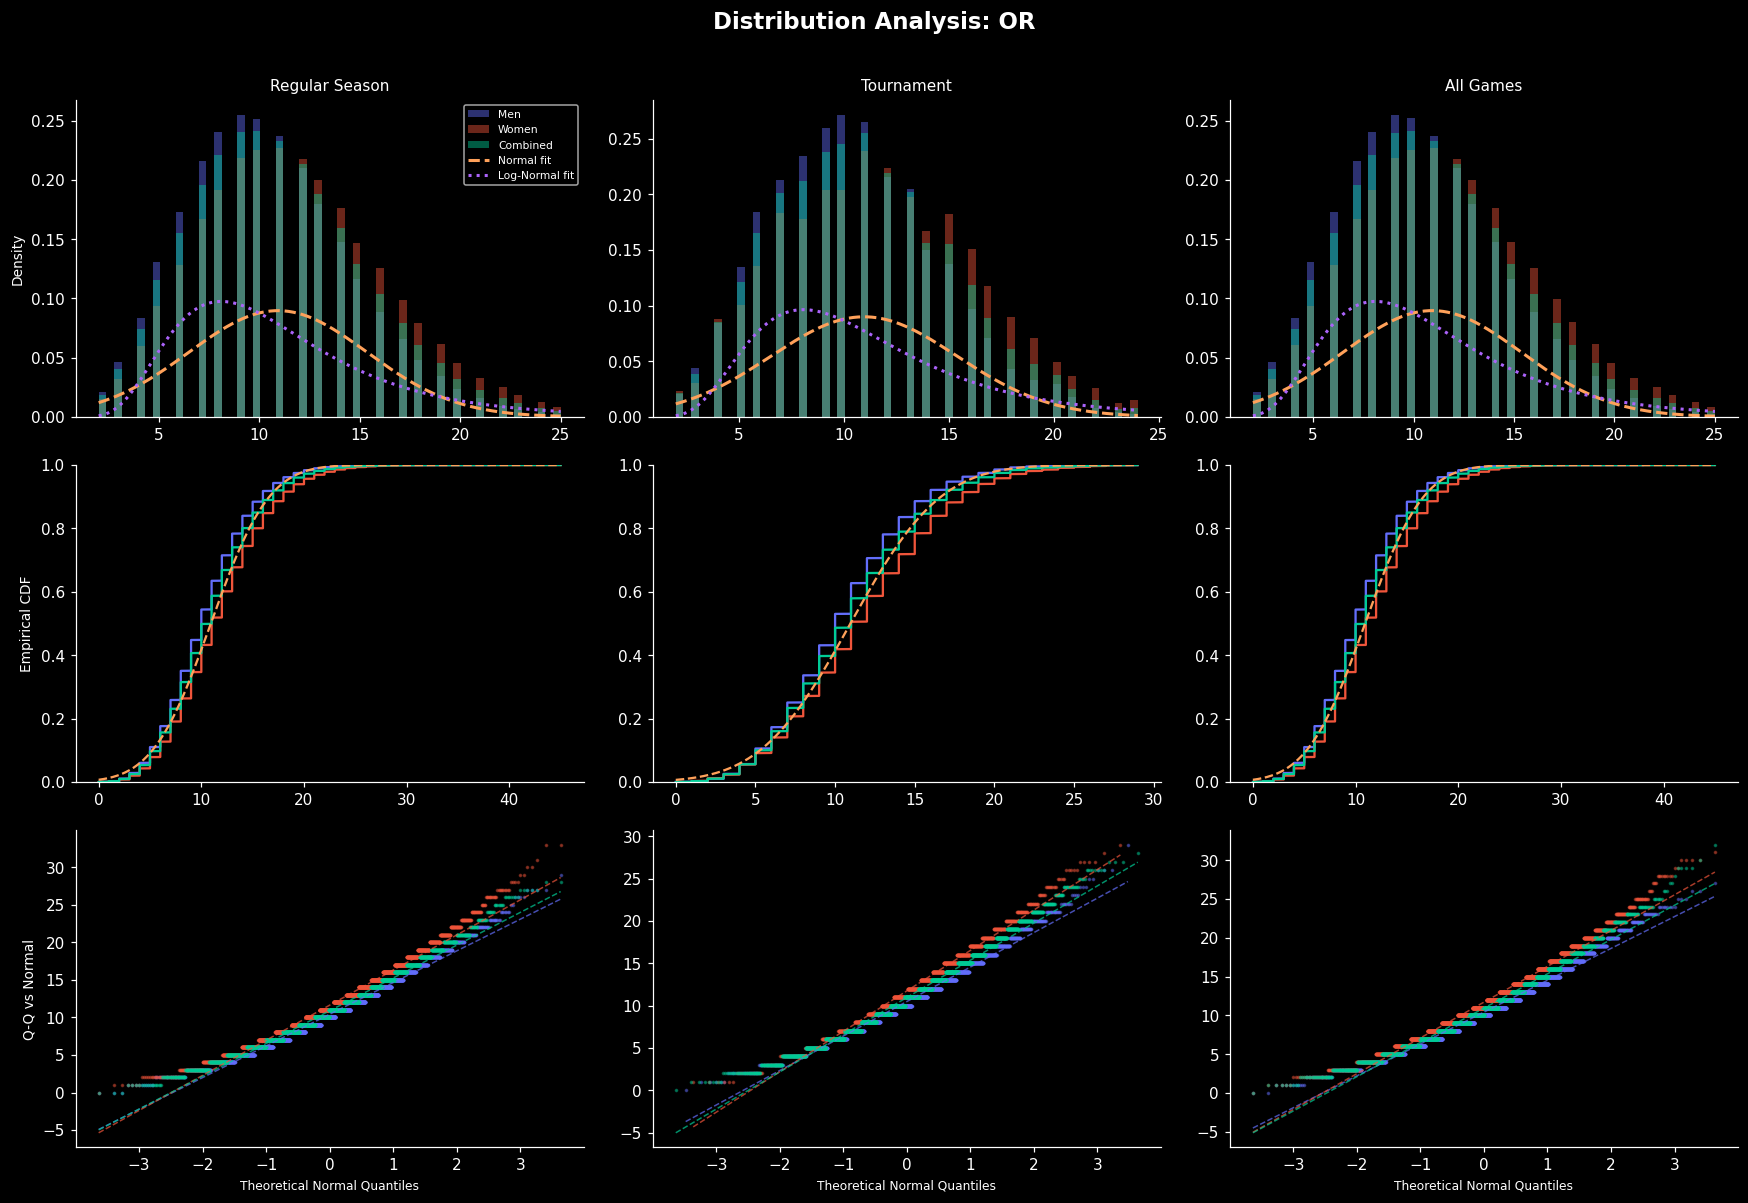

  Men       | Regular Season   n= 237,764  mean= 10.40  std= 4.17  skew=+0.53  exkurt=+0.38  p=0.0e+00  → mildly right-skewed
  Women     | Regular Season   n= 163,416  mean= 11.70  std= 4.71  skew=+0.54  exkurt=+0.40  p=0.0e+00  → mildly right-skewed
  Combined  | Regular Season   n= 802,360  mean= 10.93  std= 4.45  skew=+0.57  exkurt=+0.49  p=0.0e+00  → mildly right-skewed
  Men       | Tournament       n=   2,764  mean= 10.47  std= 4.10  skew=+0.45  exkurt=+0.19  p=3.8e-20  → approx. normal


  Women     | Tournament       n=   1,788  mean= 11.73  std= 4.80  skew=+0.37  exkurt=-0.06  p=4.2e-09  → approx. normal
  Combined  | Tournament       n=   9,104  mean= 10.96  std= 4.43  skew=+0.47  exkurt=+0.16  p=1.4e-67  → approx. normal


  Men       | All Games        n= 240,528  mean= 10.40  std= 4.17  skew=+0.53  exkurt=+0.37  p=0.0e+00  → mildly right-skewed
  Women     | All Games        n= 165,204  mean= 11.70  std= 4.71  skew=+0.54  exkurt=+0.40  p=0.0e+00  → mildly right-skewed
  Combined  | All Games        n= 811,464  mean= 10.93  std= 4.45  skew=+0.57  exkurt=+0.48  p=0.0e+00  → mildly right-skewed

────────────────────────────────────────────────────────────  Ast


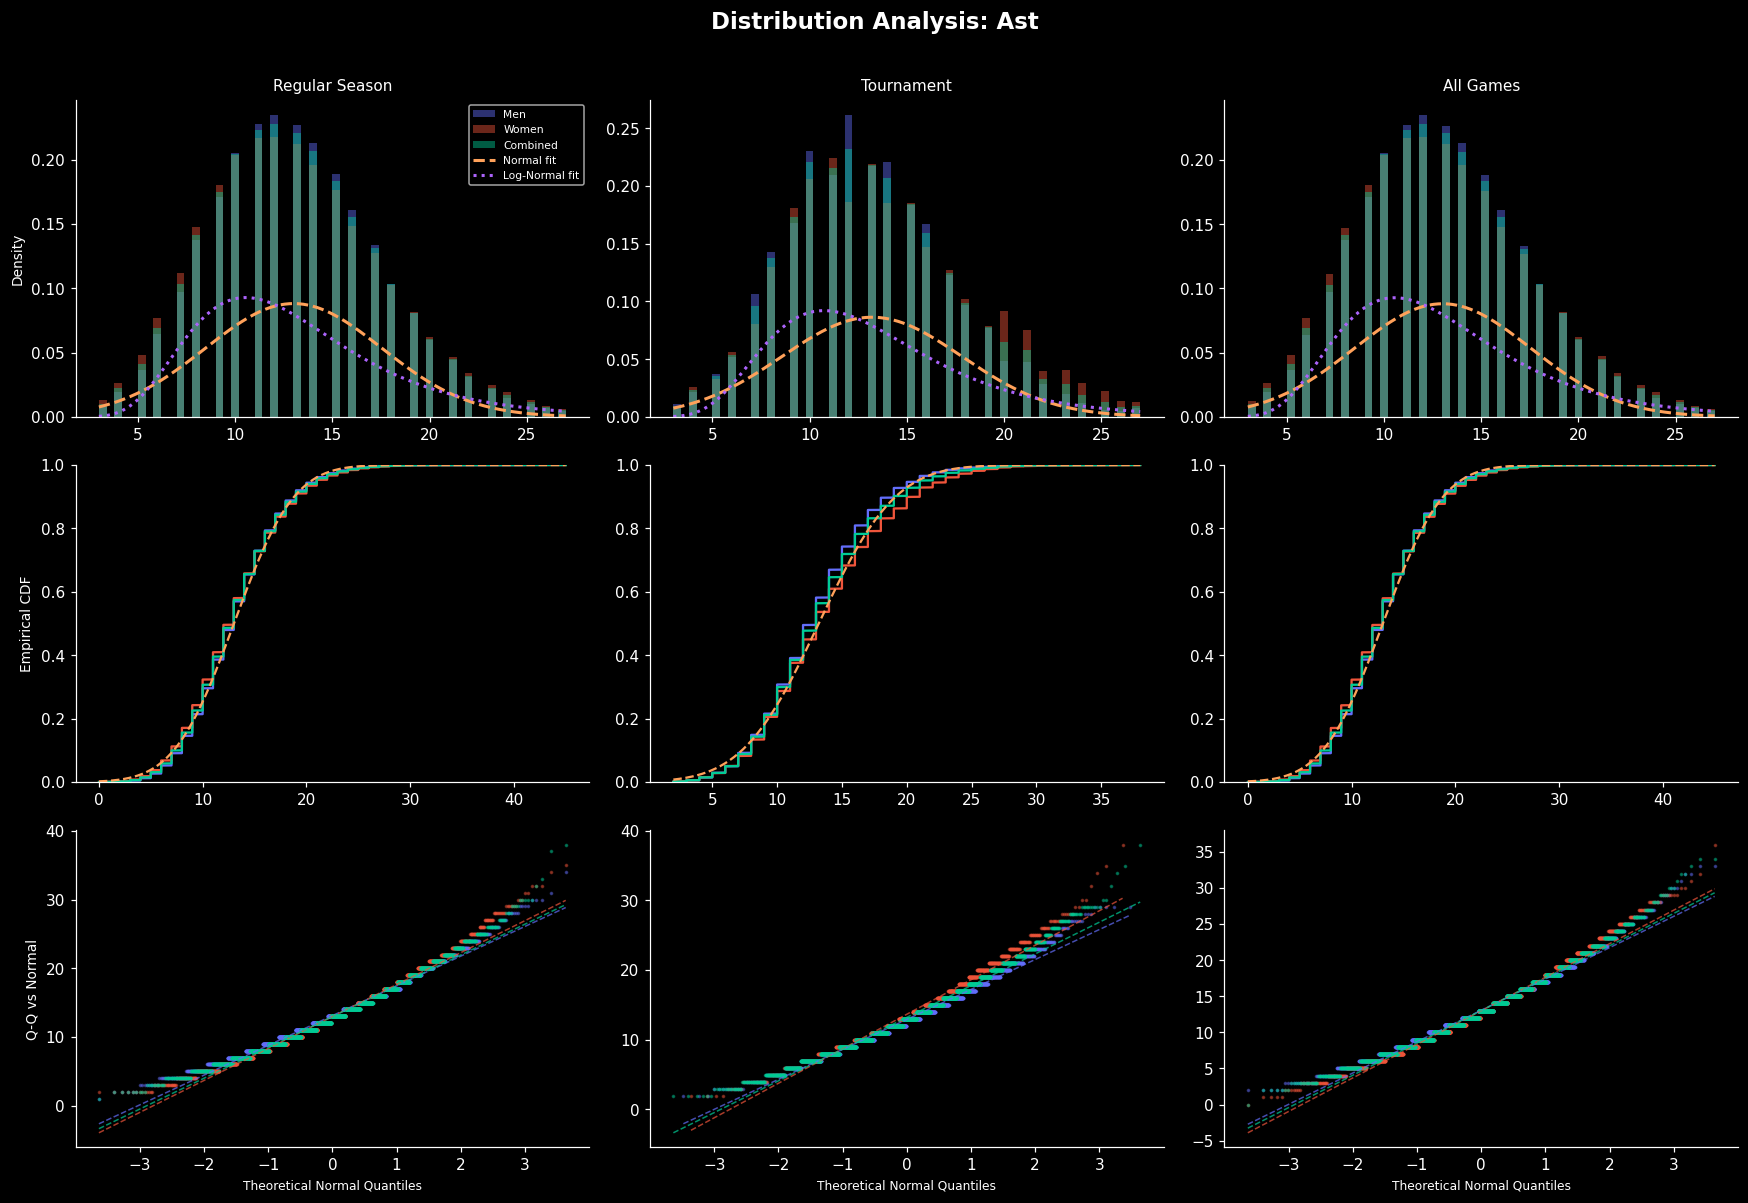

  Men       | Regular Season   n= 237,764  mean= 13.06  std= 4.41  skew=+0.47  exkurt=+0.37  p=0.0e+00  → approx. normal
  Women     | Regular Season   n= 163,416  mean= 12.95  std= 4.71  skew=+0.51  exkurt=+0.40  p=0.0e+00  → mildly right-skewed
  Combined  | Regular Season   n= 802,360  mean= 13.01  std= 4.53  skew=+0.49  exkurt=+0.39  p=0.0e+00  → approx. normal


  Men       | Tournament       n=   2,764  mean= 12.92  std= 4.33  skew=+0.47  exkurt=+0.36  p=6.0e-23  → approx. normal
  Women     | Tournament       n=   1,788  mean= 13.66  std= 5.01  skew=+0.61  exkurt=+0.50  p=2.3e-24  → mildly right-skewed
  Combined  | Tournament       n=   9,104  mean= 13.21  std= 4.62  skew=+0.57  exkurt=+0.56  p=9.0e-111  → mildly right-skewed


  Men       | All Games        n= 240,528  mean= 13.06  std= 4.40  skew=+0.47  exkurt=+0.37  p=0.0e+00  → approx. normal
  Women     | All Games        n= 165,204  mean= 12.96  std= 4.71  skew=+0.52  exkurt=+0.40  p=0.0e+00  → mildly right-skewed
  Combined  | All Games        n= 811,464  mean= 13.02  std= 4.53  skew=+0.49  exkurt=+0.40  p=0.0e+00  → approx. normal


In [5]:
# ── Group 2a: FGM3, FGA3, OR, Ast (low-volume / right-skewed) ─────────────────
# FGM3/FGA3: era effect — 3-point volume increased significantly post-2010.
# OR: offensive rebounds are lower-volume and more right-skewed than DR.
# Ast: assists, moderate right skew expected.

print("Note: FGM3/FGA3 have an era effect — 3-point volume increased significantly post-2010.")

for stat in ["FGM3", "FGA3", "OR", "Ast"]:
    print(f"\n{'─'*60}  {stat}")
    fig = make_stat_figure(stat, dist_df)
    plt.show()
    plt.close(fig)

    for dt in DATASET_TYPES:
        subset = dist_df[dist_df["dataset_type"] == dt]
        for g in GENDERS:
            s = subset[stat] if g == "Combined" else subset[subset["gender"] == g][stat]
            rec = distribution_stats(s, label=f"{stat} | {g} | {dt}")
            _all_stats_records.append(rec)
            if rec.get("n", 0) >= 8:
                print(
                    f"  {g:9s} | {dt:16s} "
                    f"n={rec['n']:>8,}  mean={rec['mean']:6.2f}  std={rec['std']:5.2f}  "
                    f"skew={rec['skewness']:+.2f}  exkurt={rec['excess_kurtosis']:+.2f}  "
                    f"p={rec['normaltest_pvalue']:.1e}  → {rec['shape_label']}"
                )

Blk and Stl expected to be the most right-skewed stats in the dataset.

────────────────────────────────────────────────────────────  TO


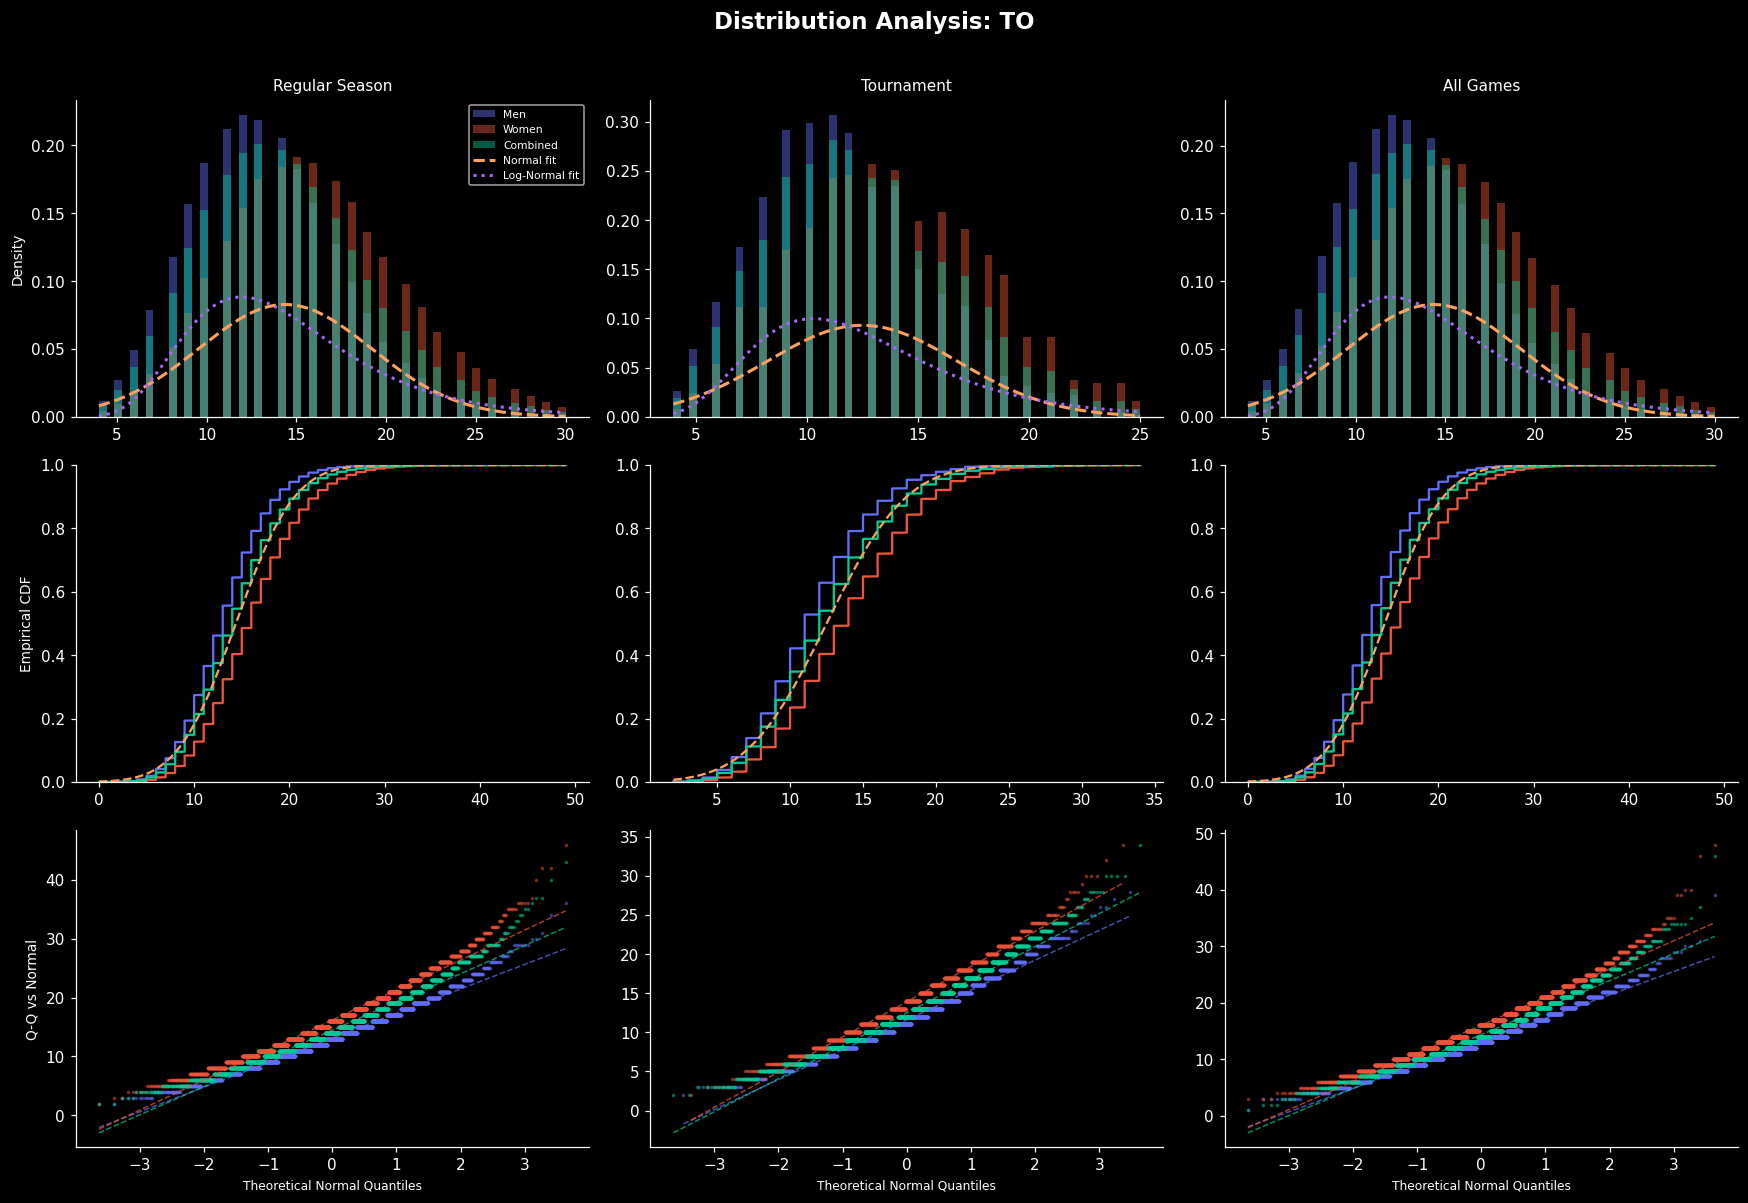

  Men       | Regular Season   n= 237,764  mean= 13.21  std= 4.26  skew=+0.47  exkurt=+0.43  p=0.0e+00  → approx. normal
  Women     | Regular Season   n= 163,416  mean= 16.08  std= 5.08  skew=+0.52  exkurt=+0.58  p=0.0e+00  → mildly right-skewed
  Combined  | Regular Season   n= 802,360  mean= 14.38  std= 4.82  skew=+0.59  exkurt=+0.71  p=0.0e+00  → mildly right-skewed
  Men       | Tournament       n=   2,764  mean= 11.58  std= 3.86  skew=+0.49  exkurt=+0.24  p=4.6e-24  → approx. normal
  Women     | Tournament       n=   1,788  mean= 13.91  std= 4.53  skew=+0.41  exkurt=+0.22  p=1.3e-11  → approx. normal
  Combined  | Tournament       n=   9,104  mean= 12.50  std= 4.29  skew=+0.54  exkurt=+0.35  p=5.6e-92  → mildly right-skewed


  Men       | All Games        n= 240,528  mean= 13.19  std= 4.26  skew=+0.47  exkurt=+0.43  p=0.0e+00  → approx. normal
  Women     | All Games        n= 165,204  mean= 16.05  std= 5.08  skew=+0.52  exkurt=+0.58  p=0.0e+00  → mildly right-skewed
  Combined  | All Games        n= 811,464  mean= 14.36  std= 4.82  skew=+0.59  exkurt=+0.70  p=0.0e+00  → mildly right-skewed

────────────────────────────────────────────────────────────  Stl


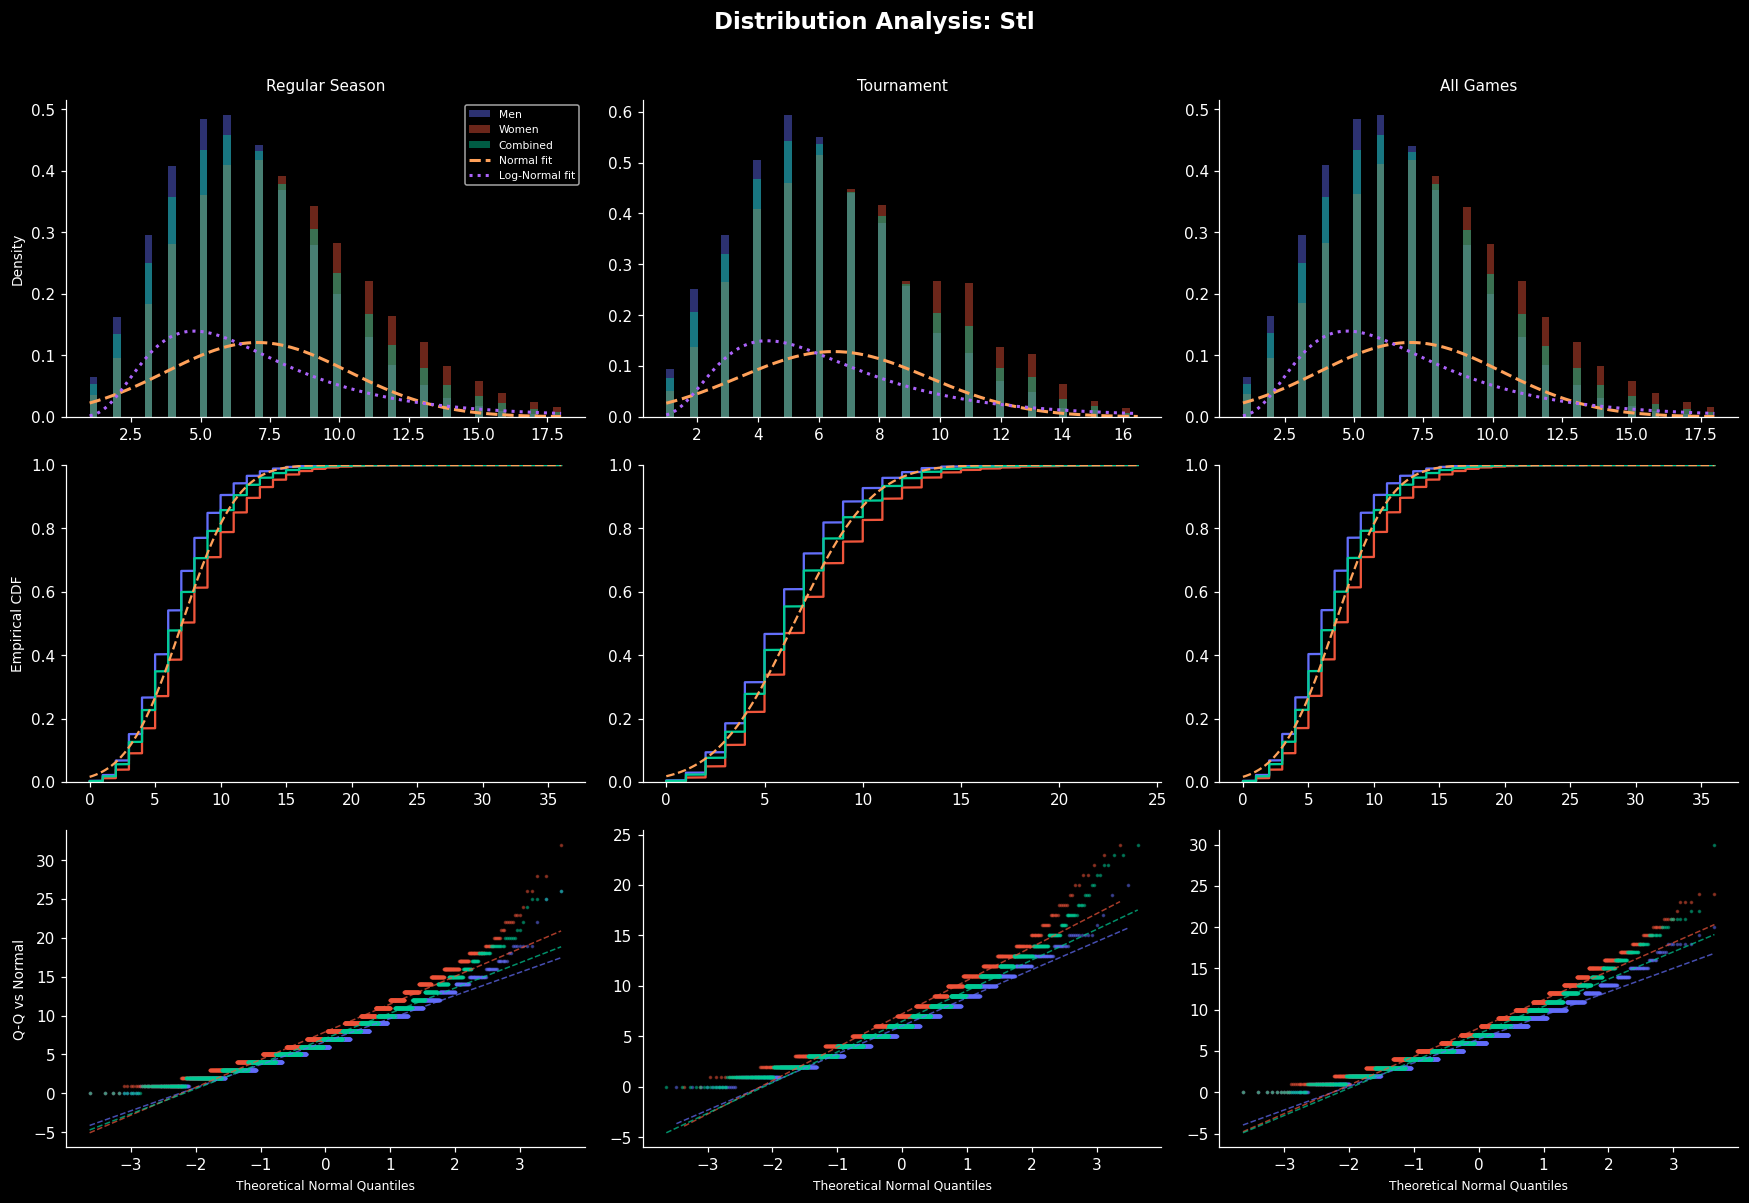

  Men       | Regular Season   n= 237,764  mean=  6.49  std= 2.97  skew=+0.62  exkurt=+0.61  p=0.0e+00  → mildly right-skewed
  Women     | Regular Season   n= 163,416  mean=  7.87  std= 3.58  skew=+0.71  exkurt=+0.89  p=0.0e+00  → mildly right-skewed
  Combined  | Regular Season   n= 802,360  mean=  7.05  std= 3.30  skew=+0.75  exkurt=+1.03  p=0.0e+00  → mildly right-skewed
  Men       | Tournament       n=   2,764  mean=  6.03  std= 2.82  skew=+0.57  exkurt=+0.37  p=1.1e-31  → mildly right-skewed


  Women     | Tournament       n=   1,788  mean=  7.22  std= 3.37  skew=+0.75  exkurt=+0.95  p=8.4e-38  → mildly right-skewed
  Combined  | Tournament       n=   9,104  mean=  6.50  std= 3.11  skew=+0.74  exkurt=+0.97  p=5.1e-183  → mildly right-skewed


  Men       | All Games        n= 240,528  mean=  6.49  std= 2.96  skew=+0.62  exkurt=+0.61  p=0.0e+00  → mildly right-skewed
  Women     | All Games        n= 165,204  mean=  7.86  std= 3.58  skew=+0.71  exkurt=+0.89  p=0.0e+00  → mildly right-skewed
  Combined  | All Games        n= 811,464  mean=  7.05  std= 3.30  skew=+0.75  exkurt=+1.03  p=0.0e+00  → mildly right-skewed

────────────────────────────────────────────────────────────  Blk


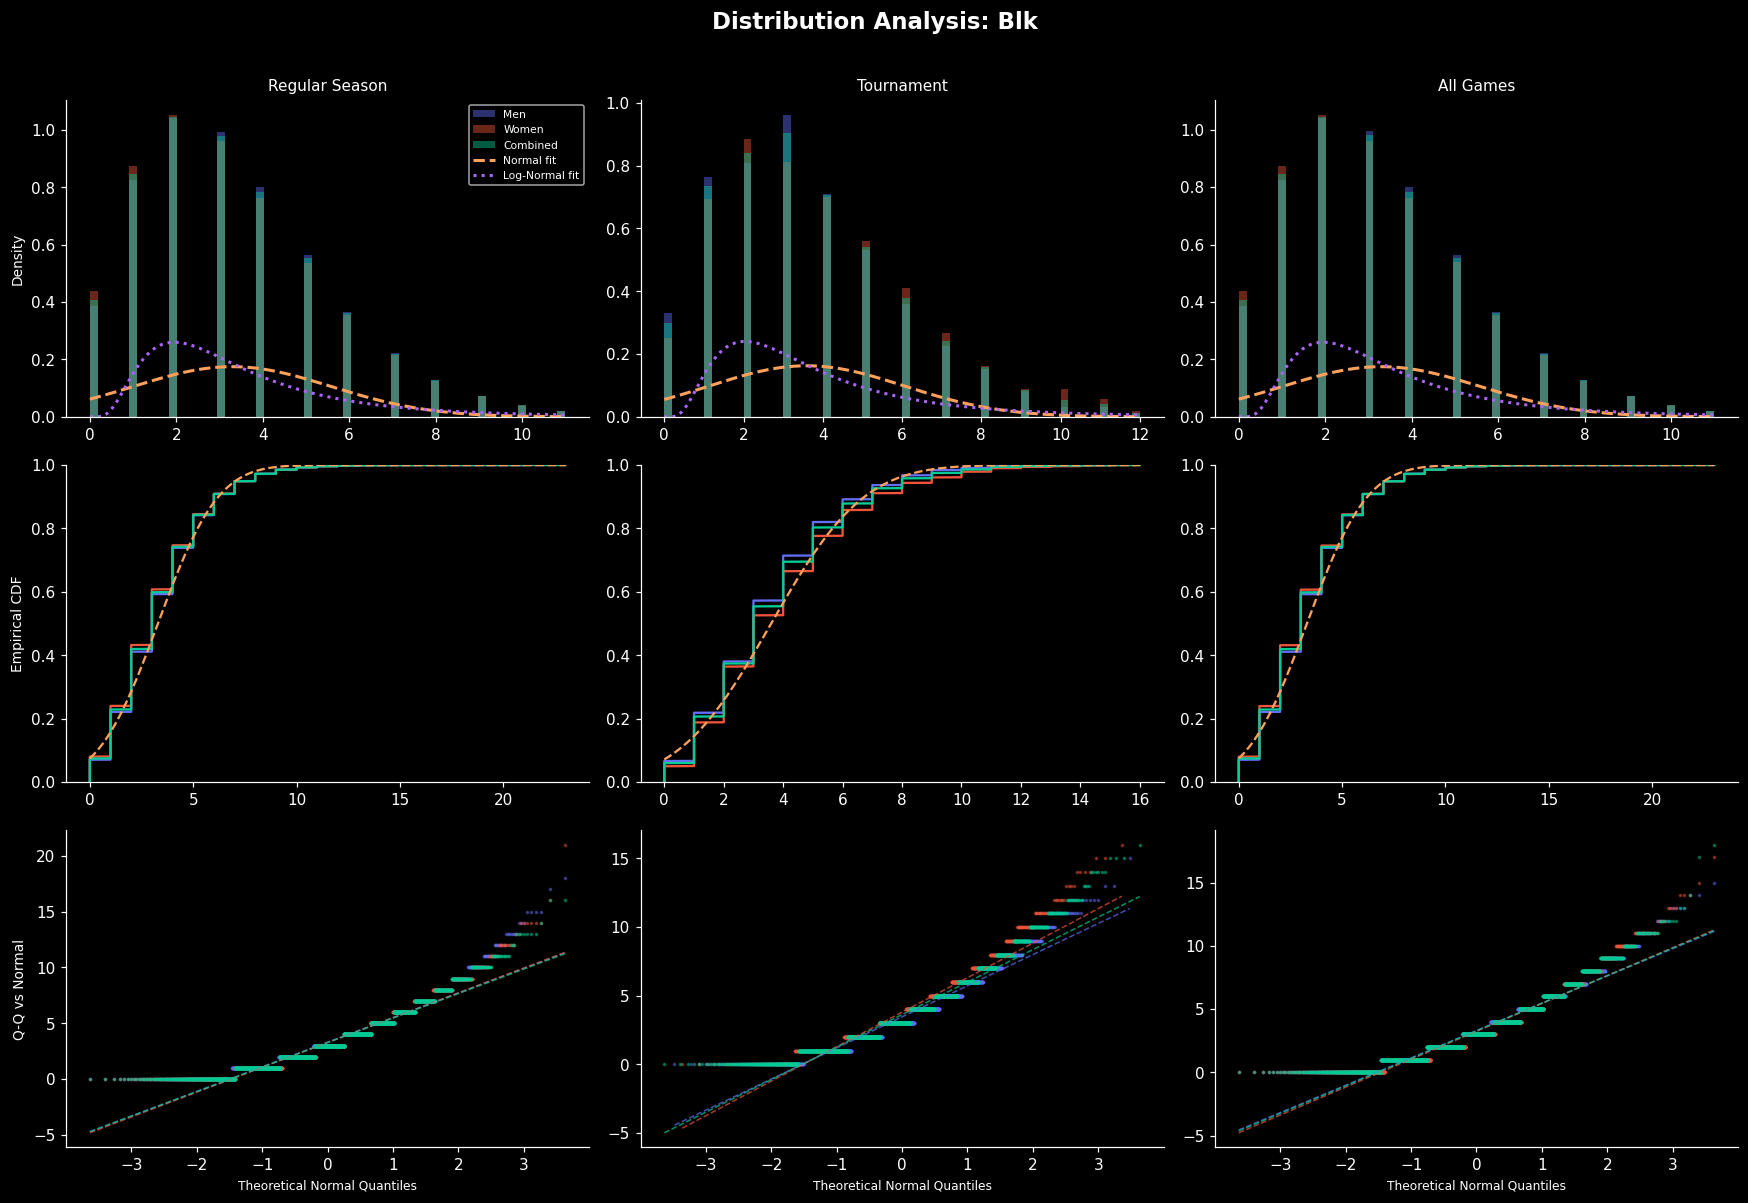

  Men       | Regular Season   n= 237,764  mean=  3.32  std= 2.27  skew=+0.96  exkurt=+1.36  p=0.0e+00  → mildly right-skewed
  Women     | Regular Season   n= 163,416  mean=  3.25  std= 2.30  skew=+0.98  exkurt=+1.33  p=0.0e+00  → mildly right-skewed
  Combined  | Regular Season   n= 802,360  mean=  3.29  std= 2.28  skew=+0.96  exkurt=+1.35  p=0.0e+00  → mildly right-skewed
  Men       | Tournament       n=   2,764  mean=  3.46  std= 2.34  skew=+0.83  exkurt=+0.70  p=7.6e-62  → mildly right-skewed
  Women     | Tournament       n=   1,788  mean=  3.80  std= 2.61  skew=+1.02  exkurt=+1.23  p=8.0e-59  → right-skewed
  Combined  | Tournament       n=   9,104  mean=  3.60  std= 2.45  skew=+0.94  exkurt=+1.07  p=7.2e-257  → mildly right-skewed


  Men       | All Games        n= 240,528  mean=  3.33  std= 2.27  skew=+0.95  exkurt=+1.36  p=0.0e+00  → mildly right-skewed
  Women     | All Games        n= 165,204  mean=  3.25  std= 2.30  skew=+0.98  exkurt=+1.34  p=0.0e+00  → mildly right-skewed
  Combined  | All Games        n= 811,464  mean=  3.30  std= 2.28  skew=+0.96  exkurt=+1.35  p=0.0e+00  → mildly right-skewed

────────────────────────────────────────────────────────────  PF


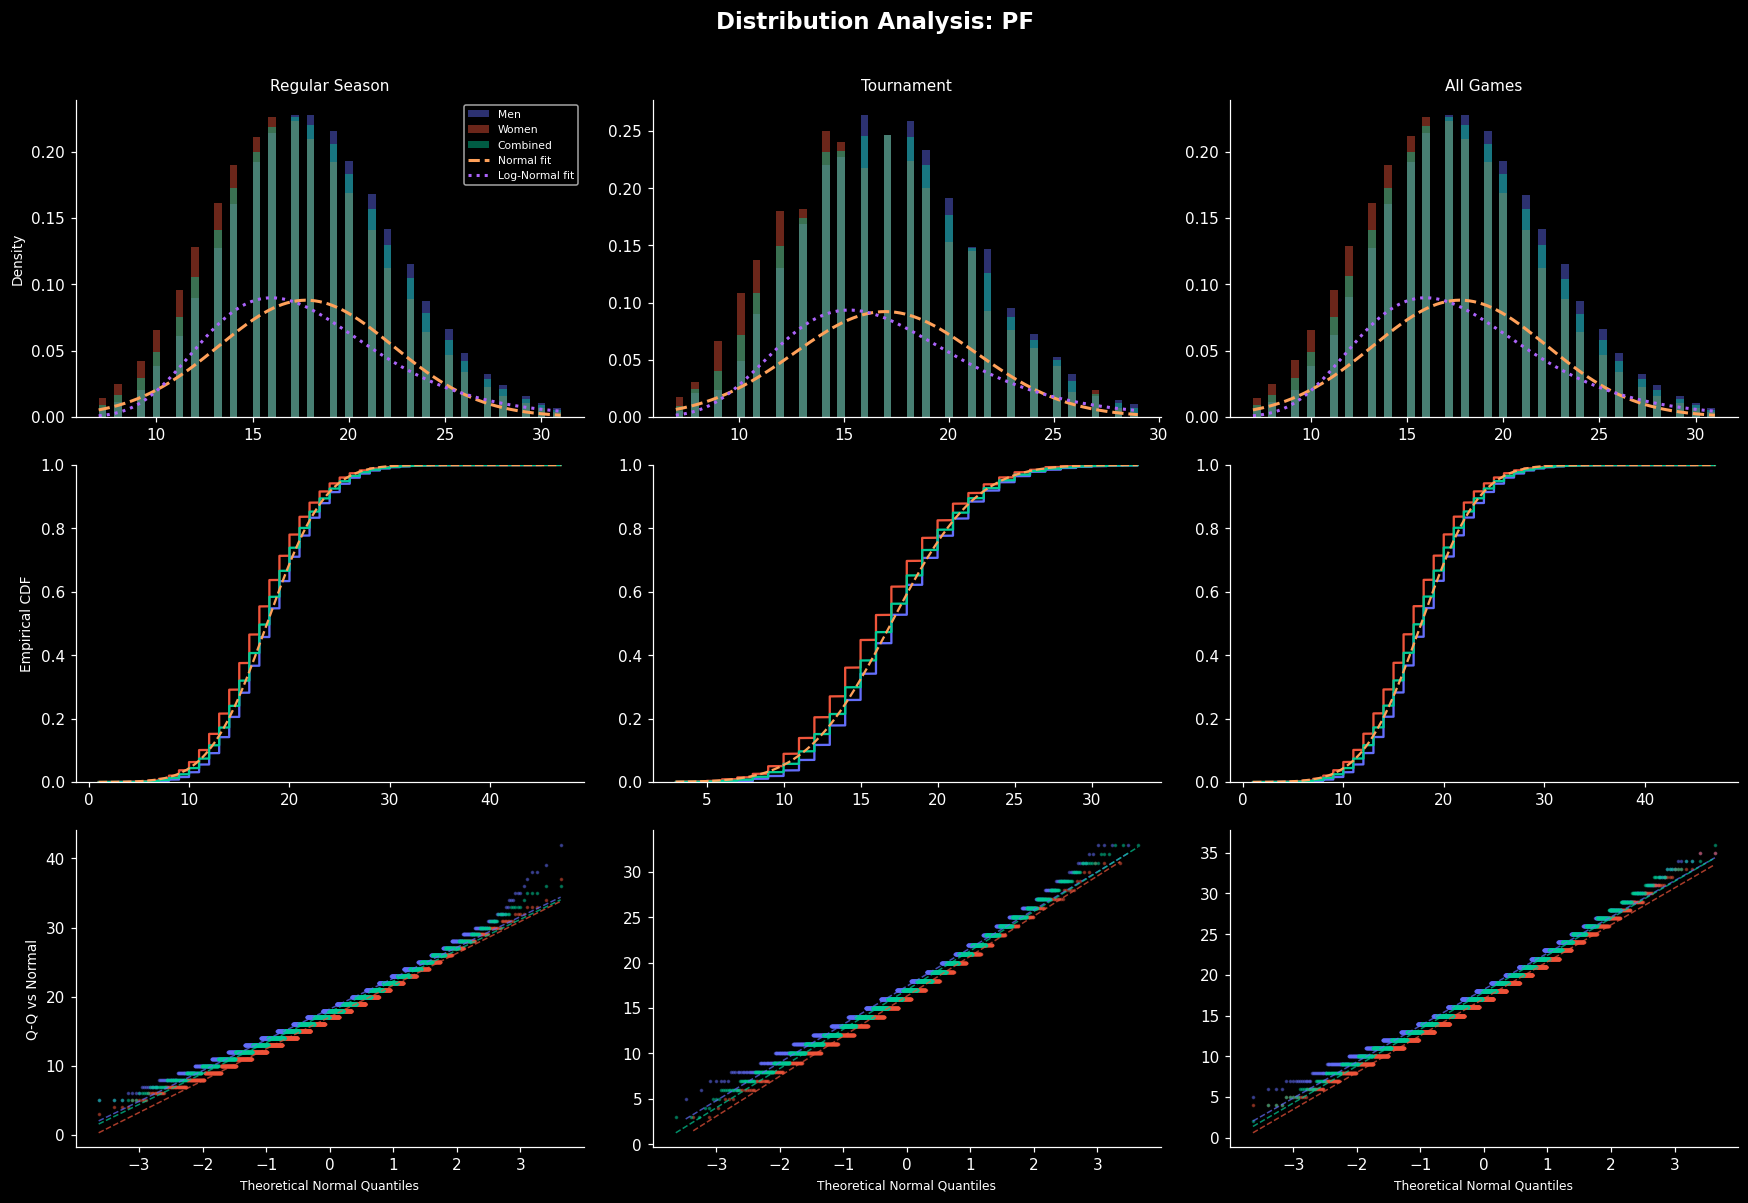

  Men       | Regular Season   n= 237,764  mean= 18.22  std= 4.48  skew=+0.34  exkurt=+0.26  p=0.0e+00  → approx. normal
  Women     | Regular Season   n= 163,416  mean= 17.11  std= 4.53  skew=+0.30  exkurt=+0.20  p=0.0e+00  → approx. normal
  Combined  | Regular Season   n= 802,360  mean= 17.77  std= 4.53  skew=+0.31  exkurt=+0.23  p=0.0e+00  → approx. normal
  Men       | Tournament       n=   2,764  mean= 17.41  std= 4.22  skew=+0.34  exkurt=+0.13  p=4.9e-12  → approx. normal
  Women     | Tournament       n=   1,788  mean= 16.31  std= 4.42  skew=+0.21  exkurt=-0.09  p=8.9e-04  → approx. normal
  Combined  | Tournament       n=   9,104  mean= 16.98  std= 4.33  skew=+0.26  exkurt=+0.06  p=6.1e-23  → approx. normal


  Men       | All Games        n= 240,528  mean= 18.21  std= 4.47  skew=+0.34  exkurt=+0.26  p=0.0e+00  → approx. normal
  Women     | All Games        n= 165,204  mean= 17.10  std= 4.53  skew=+0.30  exkurt=+0.20  p=0.0e+00  → approx. normal
  Combined  | All Games        n= 811,464  mean= 17.76  std= 4.53  skew=+0.31  exkurt=+0.23  p=0.0e+00  → approx. normal


In [6]:
# ── Group 2b: TO, Stl, Blk, PF (low-volume / right-skewed continued) ──────────
# Blk: most right-skewed stat in the dataset — rare events with heavy right tail.
# Stl: similarly right-skewed; elite steal teams are rare.
# TO: roughly symmetric at game level (winning teams turn it over less).
# PF: bounded above by foul-out rules; may show slight left skew near upper limit.

print("Blk and Stl expected to be the most right-skewed stats in the dataset.")

for stat in ["TO", "Stl", "Blk", "PF"]:
    print(f"\n{'─'*60}  {stat}")
    fig = make_stat_figure(stat, dist_df)
    plt.show()
    plt.close(fig)

    for dt in DATASET_TYPES:
        subset = dist_df[dist_df["dataset_type"] == dt]
        for g in GENDERS:
            s = subset[stat] if g == "Combined" else subset[subset["gender"] == g][stat]
            rec = distribution_stats(s, label=f"{stat} | {g} | {dt}")
            _all_stats_records.append(rec)
            if rec.get("n", 0) >= 8:
                print(
                    f"  {g:9s} | {dt:16s} "
                    f"n={rec['n']:>8,}  mean={rec['mean']:6.2f}  std={rec['std']:5.2f}  "
                    f"skew={rec['skewness']:+.2f}  exkurt={rec['excess_kurtosis']:+.2f}  "
                    f"p={rec['normaltest_pvalue']:.1e}  → {rec['shape_label']}"
                )

All bounded [0,1] rates → logit transform recommended for modeling.
Log-Normal PDF overlay is suppressed for bounded stats.

────────────────────────────────────────────────────────────  FGPct


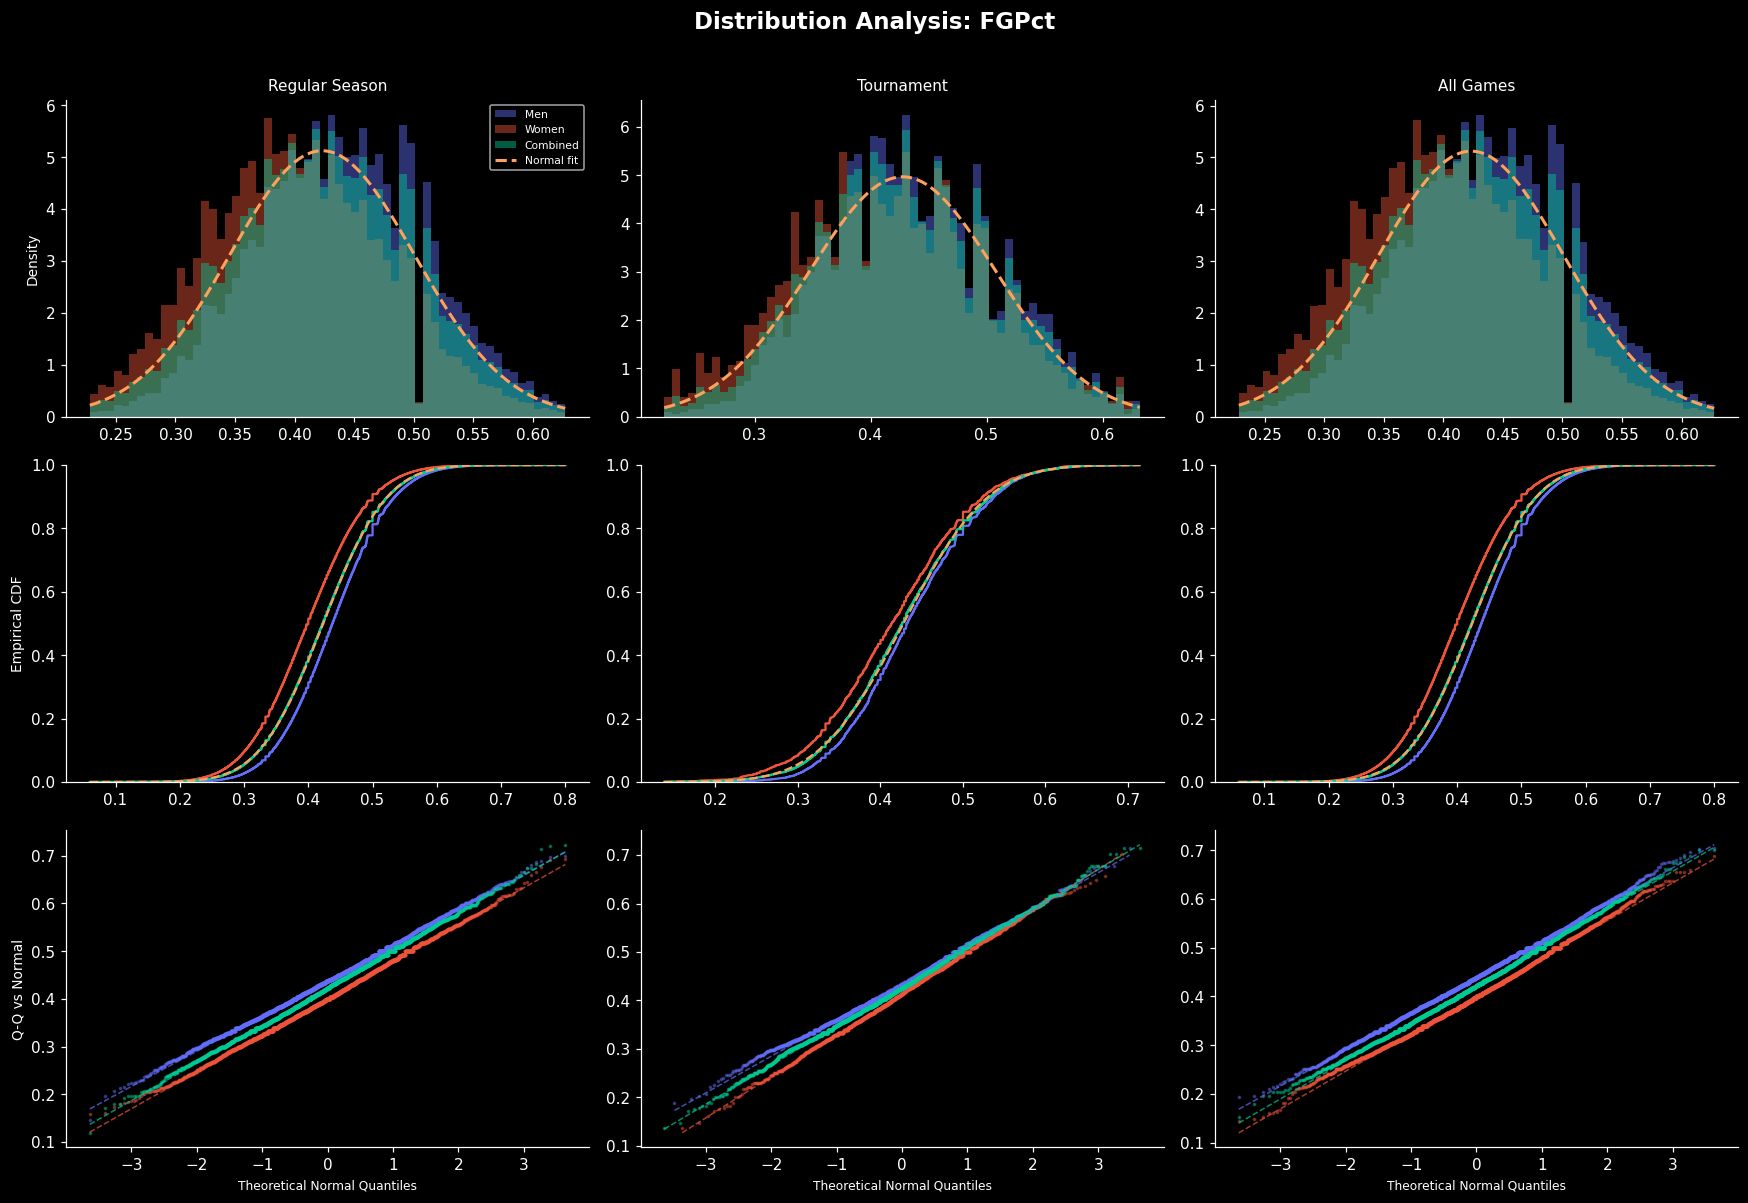

  Men       | Regular Season   n= 237,764  mean=0.4389  std=0.0742  skew=+0.10  exkurt=-0.01  p=2.3e-79  → bounded [0,1]
  Women     | Regular Season   n= 163,416  mean=0.4004  std=0.0775  skew=+0.12  exkurt=-0.01  p=9.0e-85  → bounded [0,1]
  Combined  | Regular Season   n= 802,360  mean=0.4232  std=0.0779  skew=+0.06  exkurt=-0.02  p=1.4e-115  → bounded [0,1]
  Men       | Tournament       n=   2,764  mean=0.4364  std=0.0757  skew=+0.16  exkurt=-0.13  p=1.2e-03  → bounded [0,1]
  Women     | Tournament       n=   1,788  mean=0.4143  std=0.0853  skew=+0.01  exkurt=-0.12  p=5.7e-01  → bounded [0,1]
  Combined  | Tournament       n=   9,104  mean=0.4277  std=0.0804  skew=+0.04  exkurt=-0.05  p=2.3e-01  → bounded [0,1]


  Men       | All Games        n= 240,528  mean=0.4388  std=0.0742  skew=+0.10  exkurt=-0.01  p=1.5e-81  → bounded [0,1]
  Women     | All Games        n= 165,204  mean=0.4005  std=0.0776  skew=+0.12  exkurt=-0.01  p=2.7e-85  → bounded [0,1]
  Combined  | All Games        n= 811,464  mean=0.4232  std=0.0779  skew=+0.06  exkurt=-0.03  p=2.4e-116  → bounded [0,1]

────────────────────────────────────────────────────────────  3PPct


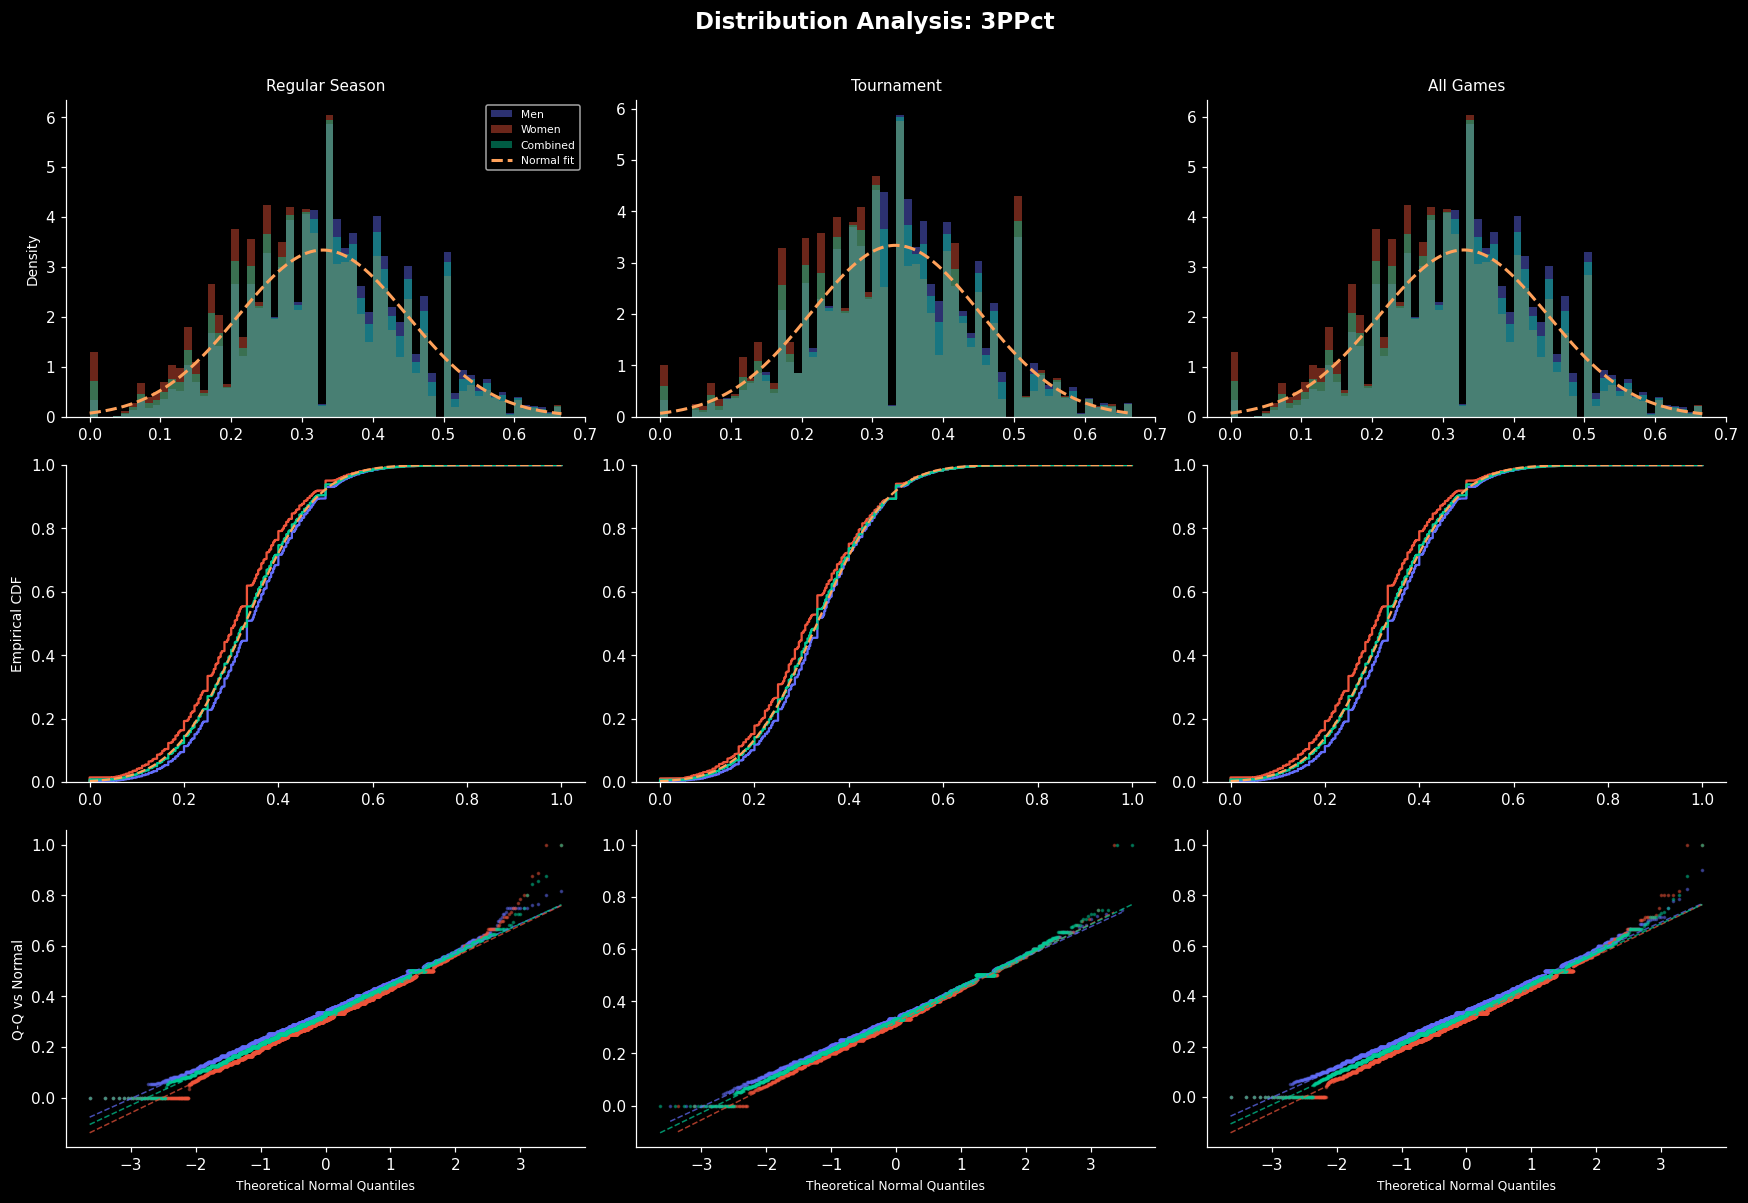

  Men       | Regular Season   n= 237,764  mean=0.3425  std=0.1152  skew=+0.15  exkurt=+0.26  p=0.0e+00  → bounded [0,1]
  Women     | Regular Season   n= 163,416  mean=0.3105  std=0.1229  skew=+0.20  exkurt=+0.45  p=0.0e+00  → bounded [0,1]
  Combined  | Regular Season   n= 802,360  mean=0.3295  std=0.1195  skew=+0.15  exkurt=+0.33  p=0.0e+00  → bounded [0,1]
  Men       | Tournament       n=   2,764  mean=0.3404  std=0.1150  skew=+0.14  exkurt=+0.10  p=7.5e-03  → bounded [0,1]
  Women     | Tournament       n=   1,788  mean=0.3207  std=0.1253  skew=+0.20  exkurt=+0.35  p=5.4e-05  → bounded [0,1]
  Combined  | Tournament       n=   9,104  mean=0.3326  std=0.1195  skew=+0.15  exkurt=+0.22  p=4.1e-11  → bounded [0,1]


  Men       | All Games        n= 240,528  mean=0.3424  std=0.1152  skew=+0.15  exkurt=+0.26  p=0.0e+00  → bounded [0,1]
  Women     | All Games        n= 165,204  mean=0.3106  std=0.1230  skew=+0.20  exkurt=+0.45  p=0.0e+00  → bounded [0,1]
  Combined  | All Games        n= 811,464  mean=0.3295  std=0.1195  skew=+0.15  exkurt=+0.33  p=0.0e+00  → bounded [0,1]

────────────────────────────────────────────────────────────  FTPct


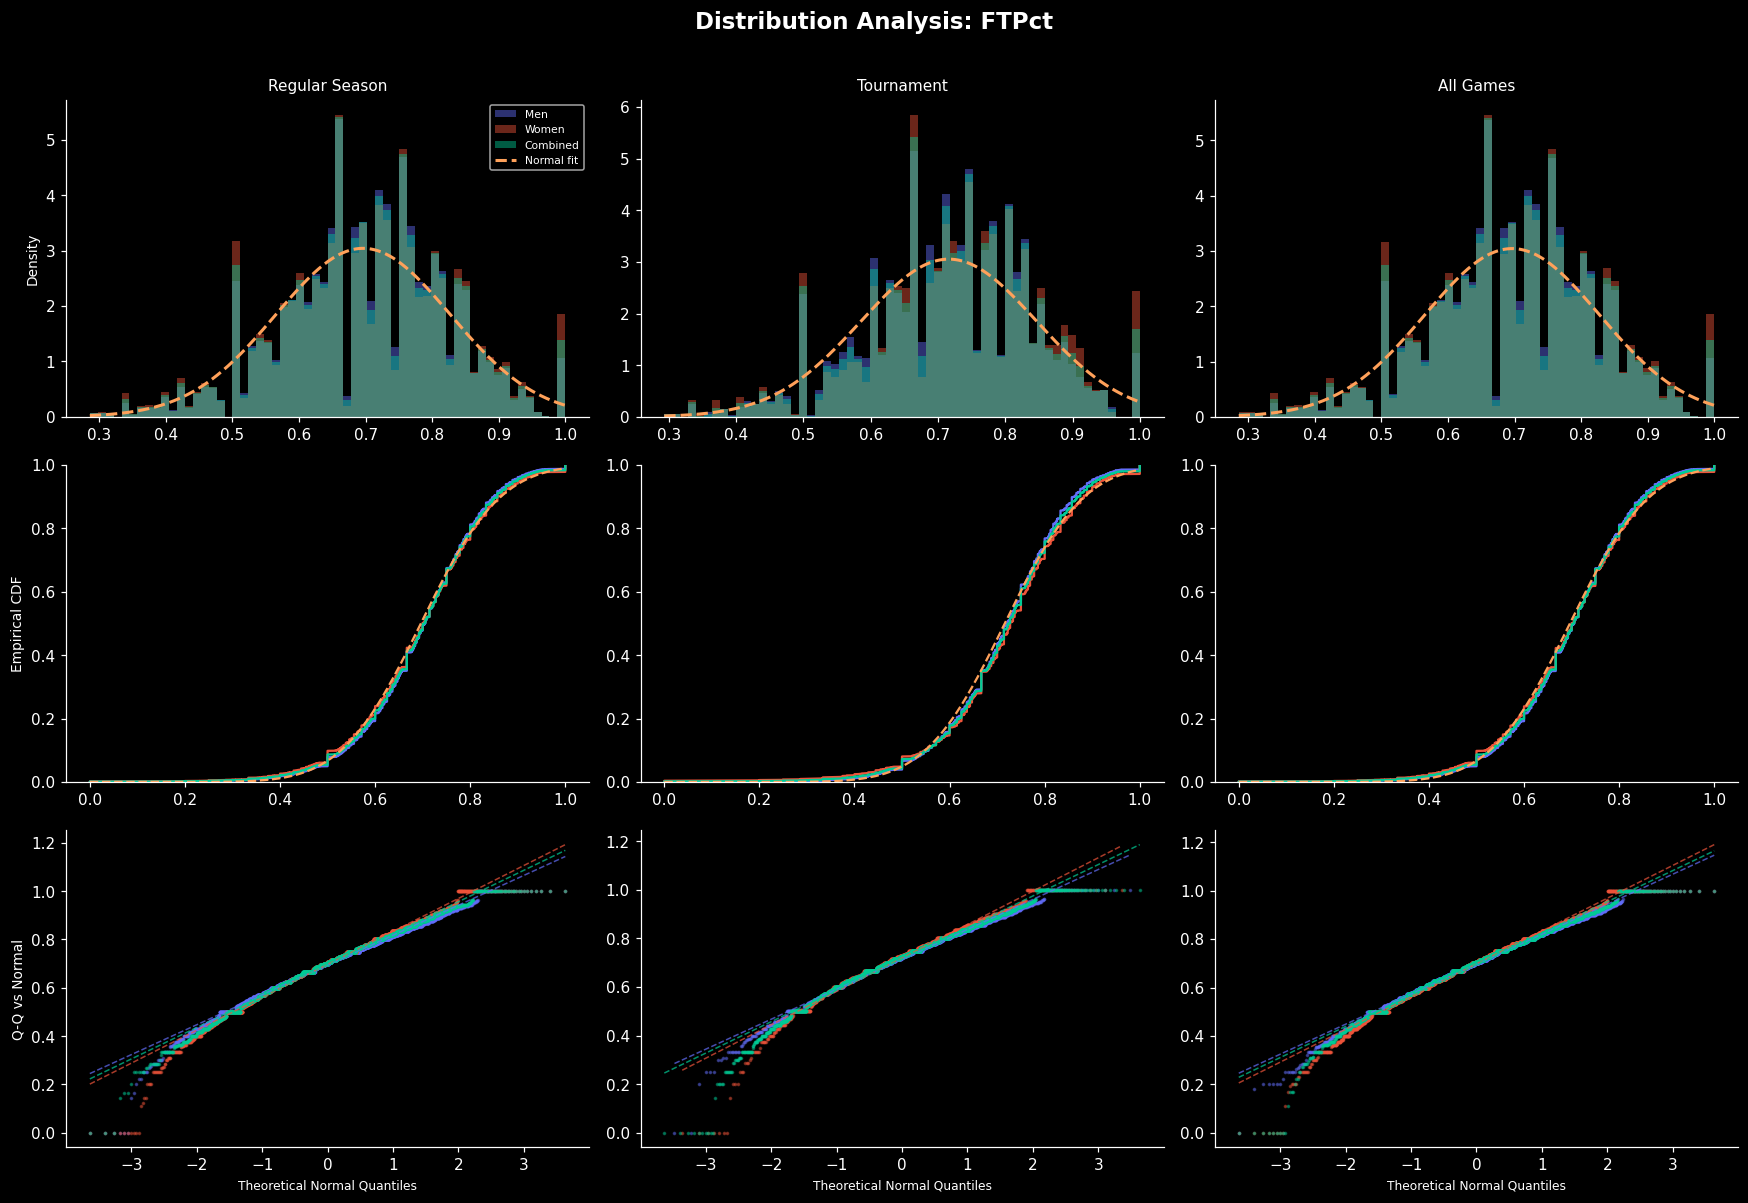

  Men       | Regular Season   n= 237,764  mean=0.6969  std=0.1263  skew=-0.47  exkurt=+1.04  p=0.0e+00  → bounded [0,1]
  Women     | Regular Season   n= 163,416  mean=0.6951  std=0.1379  skew=-0.50  exkurt=+1.17  p=0.0e+00  → bounded [0,1]
  Combined  | Regular Season   n= 802,360  mean=0.6962  std=0.1311  skew=-0.48  exkurt=+1.14  p=0.0e+00  → bounded [0,1]
  Men       | Tournament       n=   2,764  mean=0.7138  std=0.1240  skew=-0.49  exkurt=+0.97  p=1.0e-33  → bounded [0,1]
  Women     | Tournament       n=   1,788  mean=0.7194  std=0.1402  skew=-0.90  exkurt=+2.72  p=2.2e-66  → bounded [0,1]
  Combined  | Tournament       n=   9,104  mean=0.7160  std=0.1306  skew=-0.68  exkurt=+1.91  p=3.2e-216  → bounded [0,1]


  Men       | All Games        n= 240,528  mean=0.6971  std=0.1263  skew=-0.47  exkurt=+1.04  p=0.0e+00  → bounded [0,1]
  Women     | All Games        n= 165,204  mean=0.6954  std=0.1379  skew=-0.50  exkurt=+1.18  p=0.0e+00  → bounded [0,1]
  Combined  | All Games        n= 811,464  mean=0.6964  std=0.1311  skew=-0.49  exkurt=+1.15  p=0.0e+00  → bounded [0,1]

────────────────────────────────────────────────────────────  TO_rate


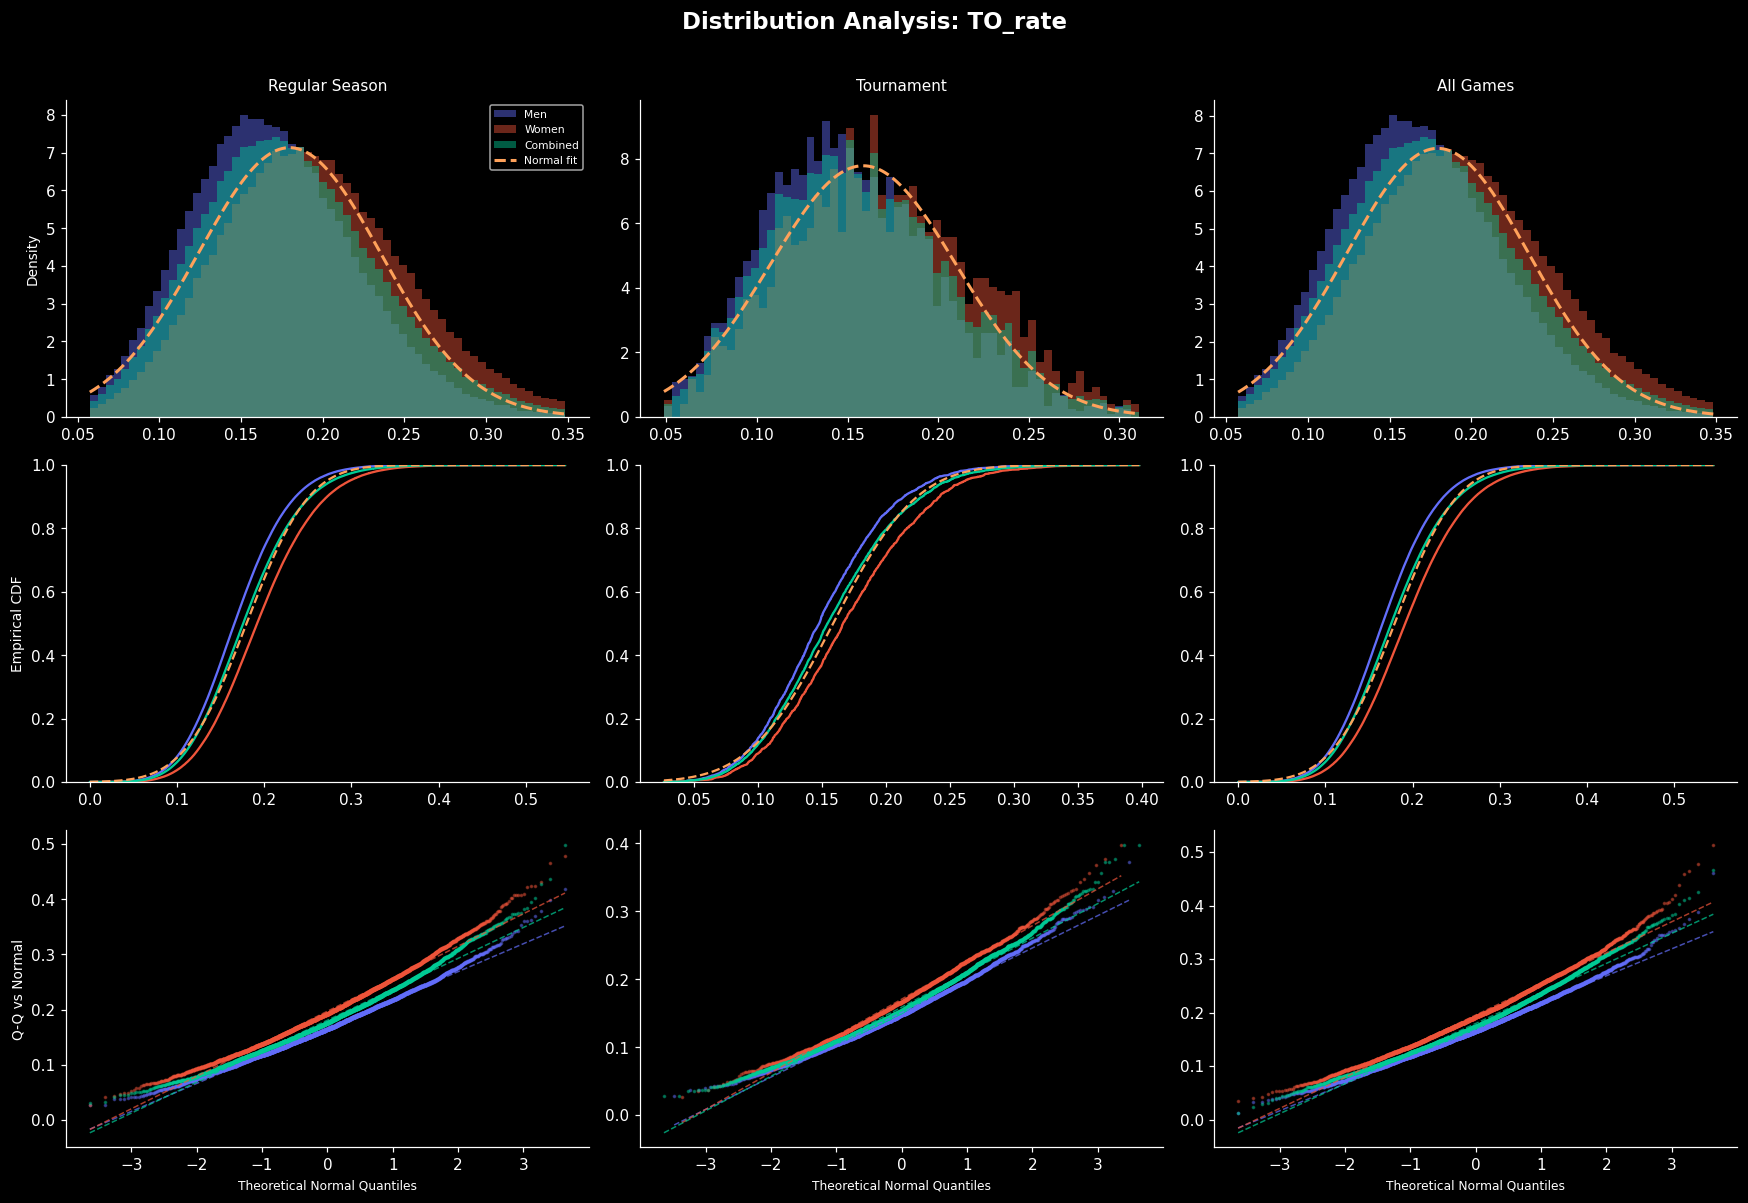

  Men       | Regular Season   n= 237,764  mean=0.1688  std=0.0513  skew=+0.36  exkurt=+0.22  p=0.0e+00  → bounded [0,1]
  Women     | Regular Season   n= 163,416  mean=0.1956  std=0.0585  skew=+0.41  exkurt=+0.33  p=0.0e+00  → bounded [0,1]
  Combined  | Regular Season   n= 802,360  mean=0.1797  std=0.0559  skew=+0.45  exkurt=+0.40  p=0.0e+00  → bounded [0,1]
  Men       | Tournament       n=   2,764  mean=0.1508  std=0.0477  skew=+0.42  exkurt=+0.17  p=9.0e-18  → bounded [0,1]
  Women     | Tournament       n=   1,788  mean=0.1705  std=0.0542  skew=+0.37  exkurt=+0.12  p=1.6e-09  → bounded [0,1]
  Combined  | Tournament       n=   9,104  mean=0.1586  std=0.0513  skew=+0.45  exkurt=+0.23  p=1.5e-65  → bounded [0,1]


  Men       | All Games        n= 240,528  mean=0.1686  std=0.0513  skew=+0.36  exkurt=+0.22  p=0.0e+00  → bounded [0,1]
  Women     | All Games        n= 165,204  mean=0.1953  std=0.0585  skew=+0.41  exkurt=+0.33  p=0.0e+00  → bounded [0,1]
  Combined  | All Games        n= 811,464  mean=0.1795  std=0.0559  skew=+0.45  exkurt=+0.40  p=0.0e+00  → bounded [0,1]


In [7]:
# ── Group 3: FGPct, 3PPct, FTPct, TO_rate (bounded [0,1] efficiency rates) ────
# These are ratios bounded to [0,1]. Log-Normal fit is not meaningful here.
# FTPct: expected left-skewed (most teams shoot >60% from the line).
# 3PPct: most spread; ranges ~28–42% for typical teams.
# TO_rate: roughly symmetric around 18–22%.
# → Logit transform is appropriate for all of these before modeling.

print("All bounded [0,1] rates → logit transform recommended for modeling.")
print("Log-Normal PDF overlay is suppressed for bounded stats.")

for stat in ["FGPct", "3PPct", "FTPct", "TO_rate"]:
    print(f"\n{'─'*60}  {stat}")
    fig = make_stat_figure(stat, dist_df)
    plt.show()
    plt.close(fig)

    for dt in DATASET_TYPES:
        subset = dist_df[dist_df["dataset_type"] == dt]
        for g in GENDERS:
            s = subset[stat] if g == "Combined" else subset[subset["gender"] == g][stat]
            rec = distribution_stats(s, label=f"{stat} | {g} | {dt}")
            _all_stats_records.append(rec)
            if rec.get("n", 0) >= 8:
                print(
                    f"  {g:9s} | {dt:16s} "
                    f"n={rec['n']:>8,}  mean={rec['mean']:.4f}  std={rec['std']:.4f}  "
                    f"skew={rec['skewness']:+.2f}  exkurt={rec['excess_kurtosis']:+.2f}  "
                    f"p={rec['normaltest_pvalue']:.1e}  → {rec['shape_label']}"
                )

In [8]:
# ── Summary table + append to statistical_exploration_findings.md ─────────────

summary_df = pd.DataFrame([r for r in _all_stats_records if r.get("n", 0) >= 8])
# Use apply(pd.Series) to robustly parse "stat | gender | dataset_type" labels
parsed = summary_df["label"].apply(lambda x: pd.Series(x.split(" | ")))
parsed.columns = ["stat", "gender", "dataset_type"]
summary_df = pd.concat([summary_df, parsed], axis=1)

print(f"Records: {len(summary_df)}  "
      f"dataset_types: {sorted(summary_df['dataset_type'].unique())}  "
      f"genders: {sorted(summary_df['gender'].unique())}")

# Pivot: stat × gender (All Games), showing shape label
pivot = (
    summary_df[summary_df["dataset_type"] == "All Games"]
    .pivot_table(index="stat", columns="gender", values="shape_label", aggfunc="first")
)
print("\n=== Distribution Shape Summary (All Games) ===")
print(pivot.to_string())

# Normalization recommendations: Combined × All Games, sorted by skewness desc
rec_df = (
    summary_df[
        (summary_df["gender"] == "Combined") &
        (summary_df["dataset_type"] == "All Games")
    ][["stat", "skewness", "excess_kurtosis", "normaltest_pvalue",
       "shape_label", "recommended_transform", "recommended_scaler"]]
    .set_index("stat")
    .sort_values("skewness", ascending=False)
)
print("\n=== Normalization Recommendations (Combined, All Games) ===")
print(rec_df.to_string())

# ── Append to statistical_exploration_findings.md ────────────────────────────
findings_path = Path("statistical_exploration_findings.md")

# Build markdown table
table_rows = []
for stat_name, row in rec_df.iterrows():
    table_rows.append(
        f"| {stat_name} | {row['skewness']:+.2f} | {row['excess_kurtosis']:+.2f} | "
        f"{row['shape_label']} | {row['recommended_transform']} | {row['recommended_scaler']} |\n"
    )

section = (
    "\n\n---\n"
    "## Section 7: Box-Score Statistical Distribution Analysis\n\n"
    "**Source notebook:** `notebooks/eda/03_distribution_analysis.ipynb`\n\n"
    "**Data coverage (team-game observations per stat):**\n"
    "- Men's Detailed Results: regular season (2003–2025) + tournament (2003–2024)\n"
    "- Women's Detailed Results: regular season (2010–2025) + tournament (2010–2024)\n\n"
    "### Normalization Recommendations (Combined gender, All Games)\n\n"
    "| Stat | Skewness | Excess Kurtosis | Shape | Transform | Scaler |\n"
    "|------|----------|-----------------|-------|-----------|--------|\n"
    + "".join(table_rows)
    + "\n### Key Findings\n\n"
    "- **Approx. normal (no transform needed):** Score, FGM, FGA, DR, FTM, FTA — "
    "central-limit effect from summing many possession events per game.\n"
    "- **Right-skewed (log1p recommended):** Blk, Stl, OR — rare events with heavy right "
    "tails; log1p brings them closer to normal.\n"
    "- **Mildly right-skewed (sqrt or log1p):** FGM3, FGA3, Ast, TO, PF — moderate skew; "
    "era effects present for 3-point stats (higher volumes post-2010).\n"
    "- **Bounded [0,1] (logit transform):** FGPct, 3PPct, FTPct, TO_rate — Beta-like "
    "distributions; standard Normal/log transforms are inappropriate.\n"
    "- **Men vs. Women:** Shape labels are consistent across genders. Women's data shows "
    "higher FTPct means and lower FGM3/FGA3 (smaller historical 3-point volume).\n"
    "- **Regular Season vs. Tournament:** Distributions have same shape but tighter spread "
    "in tournament (more evenly-matched teams). Transform recommendations unchanged.\n"
)

with open(findings_path, "a") as f:
    f.write(section)

print(f"\nSection 7 appended to {findings_path}")
print(f"Total stat records: {len(summary_df)}")

Records: 162  dataset_types: ['All Games', 'Regular Season', 'Tournament']  genders: ['Combined', 'Men', 'Women']

=== Distribution Shape Summary (All Games) ===
gender              Combined                  Men                Women
stat                                                                  
3PPct          bounded [0,1]        bounded [0,1]        bounded [0,1]
Ast           approx. normal       approx. normal  mildly right-skewed
Blk      mildly right-skewed  mildly right-skewed  mildly right-skewed
DR            approx. normal       approx. normal       approx. normal
FGA           approx. normal       approx. normal       approx. normal
FGA3          approx. normal       approx. normal  mildly right-skewed
FGM           approx. normal       approx. normal       approx. normal
FGM3     mildly right-skewed  mildly right-skewed  mildly right-skewed
FGPct          bounded [0,1]        bounded [0,1]        bounded [0,1]
FTA      mildly right-skewed       approx. normal  mildly